In [1]:
using Images, TiffImages, ImageMorphology, ImageBinarization
using Random, StatsBase, Statistics
using PyPlot, HDF5, Glob

In [2]:
max_dist = 200
intensity_thresh = 0.035
label_components_thresh = 6
bf_thresh = 0.045
pix_um = 438.41/(246.108)
scale_corr = 3
wt_color = "black"
mut_color = (1.0,0.35,0.0)

(1.0, 0.35, 0.0)

In [3]:
function imshowt(img)
    plt.imshow(Array{Float32}(img),cmap="gray")
    plt.axis("off")
end

function imshowc(img)
    plt.imshow(permutedims(convert(Array{Float32},channelview(img)),(2,3,1)))
    plt.axis("off")
end

function color_calc(roi,center_dists)
    r = center_dists[roi]/maximum(center_dists)
    col = (r,0,1-r)
    return col
end

color_calc (generic function with 1 method)

In [4]:
function dist_calc(pt1,pt2)
    sqrt((pt1[1]-pt2[1])^2+(pt1[2]-pt2[2])^2)
end

function get_centers(n_markers,n_segments,markers)
    centers = zeros(n_markers,2)
    for i = 1:n_segments
        marker_idx = findall(markers .== i)
        x = []; y = []
        for j in marker_idx
            append!(x,j[1]); append!(y,j[2])
        end
        try
            centers[i,1] = mean(x); centers[i,2] = mean(y)
        catch err
            print(err)
        end
    end
    return centers
end

function measure_roi(flc,n_segments,markers,segments,centers)
    dists = []; intensities = []; thetas = []
    for roi = 1:n_segments
        marker_idx = findall(markers .== roi)
        wshed_idx = findall(labels_map(segments).==roi)
        IJulia.clear_output()
        dist = zeros(length(wshed_idx))
        intensity = zeros(length(wshed_idx))
        theta = zeros(length(wshed_idx))
        curr_center = centers[roi,:]
        for idx = 1:length(wshed_idx)
            coord = wshed_idx[idx]
            dist[idx] = dist_calc(coord,curr_center)./pix_um
            intensity[idx] = flc[coord]
            theta[idx] = atan((coord[2]-curr_center[2]),(coord[1]-curr_center[1]))
        end
        push!(dists,dist); push!(intensities,intensity); push!(thetas,theta)
    end
    return dists, intensities, thetas
end

measure_roi (generic function with 1 method)

In [5]:
input_dir_wt = "/home/stednitz/data/collabs/marco/Image analysis kcnj13 paper/Tg(kita_mCherry) WT and kcnj13XG6/wild-type/"
tiff_list_wt = glob("*tif",input_dir_wt)
input_dir_mut = "/home/stednitz/data/collabs/marco/Image analysis kcnj13 paper/mutant/"
tiff_list_mut = glob("*tif",input_dir_mut)

5-element Vector{String}:
 "/home/stednitz/data/collabs/marco/Image analysis kcnj13 paper/mutant/mask.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 17 bytes ⋯ " kcnj13 paper/mutant/nuclei.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 40 bytes ⋯ "e-2-25mm-region2-stitched-a.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 41 bytes ⋯ "-2-25mm-region2-stitched-a1.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 41 bytes ⋯ "-2-25mm-region2-stitched-a2.tif"

In [6]:
tiff_list_wt

8-element Vector{String}:
 "/home/stednitz/data/collabs/mar" ⋯ 72 bytes ⋯ "pe/1a-adult-26mm-dmv-stitch.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 75 bytes ⋯ "1a-adult-26mm-dmv-stitch1-a.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 73 bytes ⋯ "e/1a-adult-26mm-dmv-stitch1.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 64 bytes ⋯ "/wild-type/2-25x-stitched-a.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 64 bytes ⋯ "/wild-type/2-25x-stitched-b.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 64 bytes ⋯ "/wild-type/2-25x-stitched-c.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 62 bytes ⋯ "G6/wild-type/2-25x-stitched.tif"
 "/home/stednitz/data/collabs/mar" ⋯ 54 bytes ⋯ " kcnj13XG6/wild-type/nuclei.tif"

In [7]:
img_wt = TiffImages.load(tiff_list_wt[1])
bf_wt = (img_wt[:,:,2]); fl_wt = (img_wt[:,:,1])
h_wt = size(bf_wt)[1]; w_wt = size(bf_wt)[2]
IJulia.clear_output()


nuclei_wt = Gray.(TiffImages.load(tiff_list_wt[end]))

#mask_mut = Gray.(TiffImages.load(tiff_list_mut[1]))

mut_rot = deg2rad(-10)

nuclei_mut = Gray.(TiffImages.load(tiff_list_mut[2]))
nuclei_mut = imrotate(nuclei_mut,mut_rot)

img_mut = TiffImages.load(tiff_list_mut[3])
bf_mut = imrotate(img_mut[:,:,2],mut_rot); fl_mut = imrotate(img_mut[:,:,1],mut_rot)
IJulia.clear_output()

0

In [8]:
wt_crop_y=1450:2150

mut_crop_y = 400:2900
mut_crop_x = 200:2900

bfc_wt = bf_wt[wt_crop_y,:]
flc_wt = fl_wt[wt_crop_y,:]
nuclei_wt = nuclei_wt[wt_crop_y,:]

#mask_idx = findall(mask_mut .< 0.5)
#fl_mut[mask_idx] .= 0

bfc_mut = imresize(parent(bf_mut[mut_crop_y,mut_crop_x]),ratio=1/scale_corr)
flc_mut = imresize(parent(fl_mut[mut_crop_y,mut_crop_x]),ratio=1/scale_corr)
nuclei_mut = imresize(parent(nuclei_mut[mut_crop_y,mut_crop_x]),ratio=1/scale_corr)

nan_idx = findall(isnan.(nuclei_mut))
nuclei_mut[nan_idx]

h_mut = size(bf_mut)[1]; w_mut = size(bf_mut)[2]

IJulia.clear_output()

0

In [13]:
save("bfc_wt.tif",bfc_wt)

LoadError: No applicable_savers found for UNKNOWN

In [ ]:
bfc = load("bfc_wt

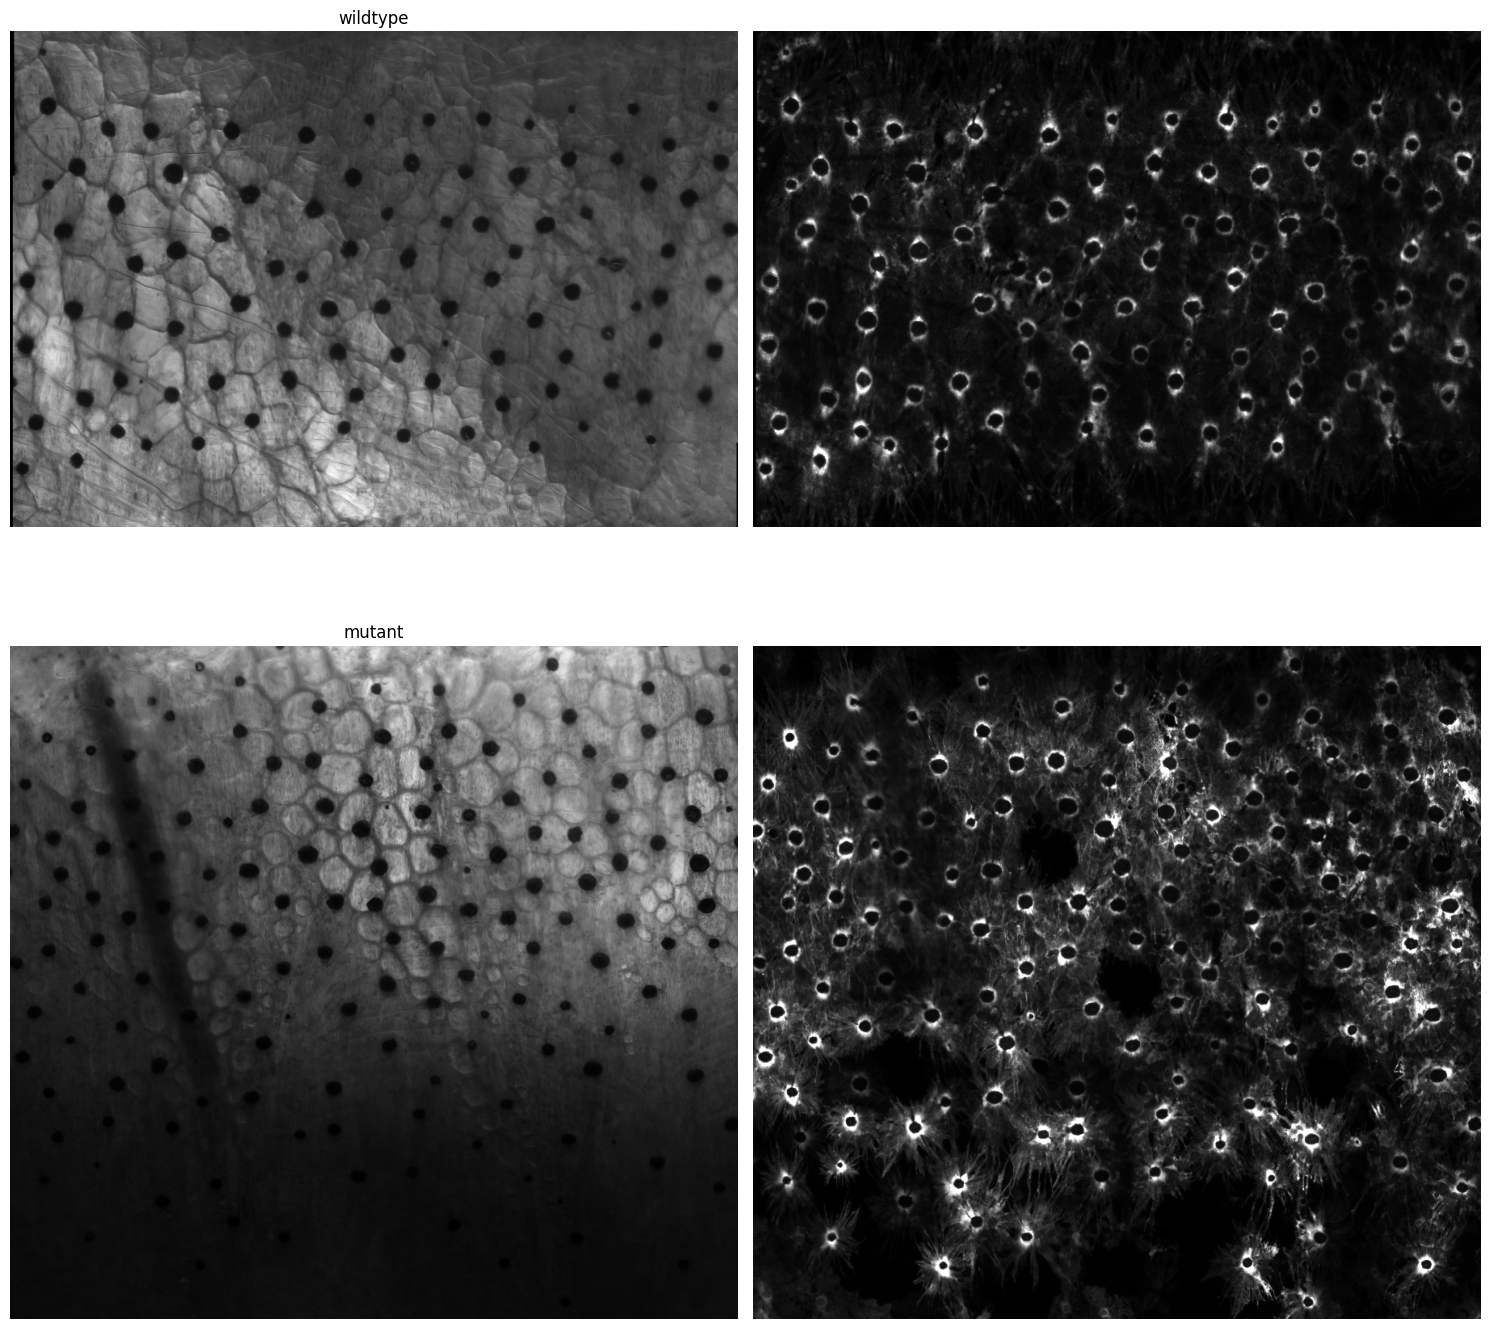

In [9]:
figure(figsize=(15,15))
subplot(221)
plt.title("wildtype")
imshowt(bfc_wt)
subplot(222)
imshowt(flc_wt)

subplot(223)
plt.title("mutant")
imshowt(bfc_mut)
subplot(224)
imshowt(flc_mut)

tight_layout()

plt.savefig("bf_fluor.svg")

In [539]:
thresh_wt = nuclei_wt .< bf_thresh
thresh_fill = dilate(erode(thresh_wt))
dist_wt = distance_transform(feature_transform(thresh_fill));
markers_wt = label_components(dist_wt .< label_components_thresh*pix_um);
segments_wt = watershed(dist_wt, markers_wt)
labels_wt = labels_map(segments_wt)
n_markers_wt = length(unique(markers_wt))
n_segments_wt = length(unique(labels_wt))
centers_wt = get_centers(n_markers_wt,n_segments_wt,markers_wt)

thresh_mut = nuclei_mut .< bf_thresh
dist_mut = distance_transform(feature_transform(thresh_mut));
markers_mut = label_components(dist_mut .< label_components_thresh*pix_um);
segments_mut = watershed(dist_mut, markers_mut)
labels_mut = labels_map(segments_mut)
n_markers_mut = length(unique(markers_mut))
n_segments_mut = length(unique(labels_mut))
centers_mut = get_centers(n_markers_mut,n_segments_mut,markers_mut)

roi_center_wt = zeros(size(thresh_wt))
roi_center_mut = zeros(size(thresh_mut))
IJulia.clear_output()

0

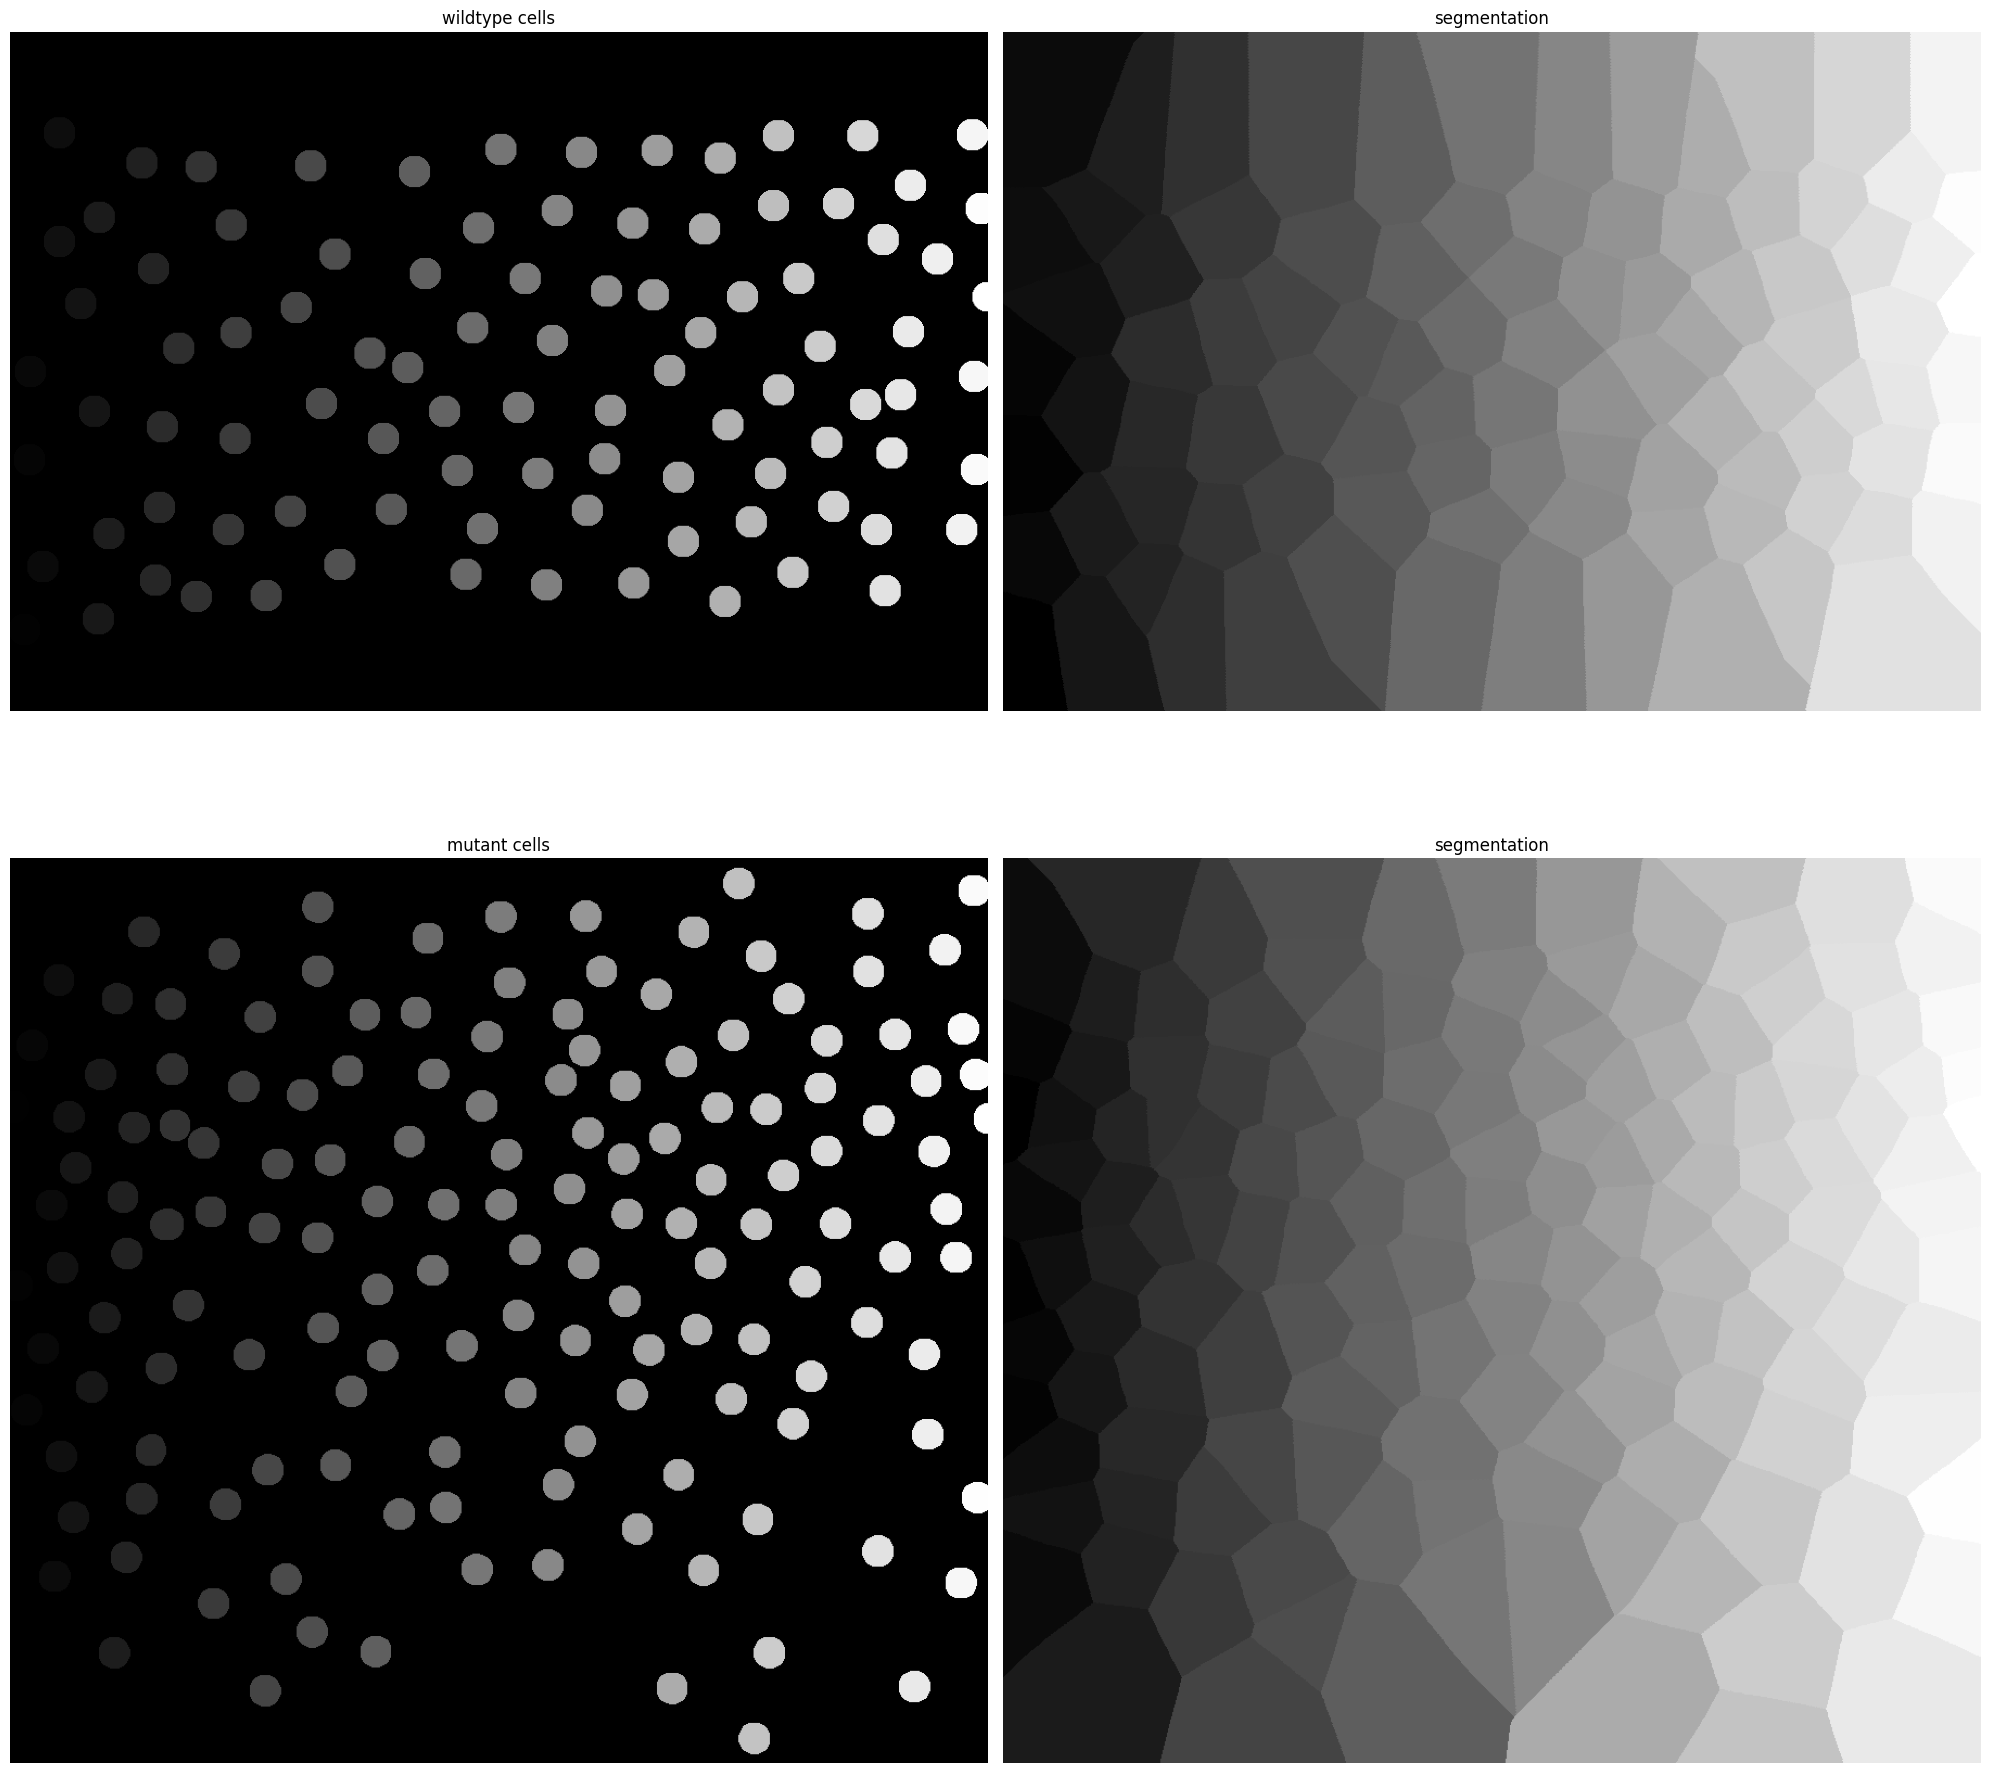

In [540]:
plt.figure(figsize=(20,20))

subplot(221)
plt.title("wildtype cells")
imshowt(markers_wt)
subplot(222)
plt.title("segmentation")
imshowt(labels_wt)

subplot(223)
plt.title("mutant cells")
imshowt(markers_mut)
subplot(224)
plt.title("segmentation")
imshowt(labels_mut)

tight_layout()
plt.savefig("segmentation.svg")

In [541]:
dists_wt,intensities_wt,thetas_wt = measure_roi(flc_wt,n_segments_wt,markers_wt,segments_wt,centers_wt)
dists_mut,intensities_mut,thetas_mut = measure_roi(flc_mut,n_segments_mut,markers_mut,segments_mut,centers_mut)

IJulia.clear_output()

0

In [542]:
function polar_hist(flc,n_cells,intensities,thetas,dists,centers)
    plt.figure(figsize=(5,5))
    vmax = 0.005
    bins = [collect(-pi:0.25pi:pi),collect(0:max_dist/9:max_dist)]
    n_rows = 10
    b=0
    polar_hists = []
    center_y = size(flc)[1]/2
    center_dists = zeros(n_cells)
    avg_vec = zeros(n_cells,2)
    for ci = 1:n_cells
        ax = plt.subplot(n_rows,Int(ceil(n_cells/n_rows)),ci,projection="polar")
        plt.title("$ci")
        valid_idx = findall(intensities[ci] .> intensity_thresh)
        t,d = thetas[ci][valid_idx],dists[ci][valid_idx]
        c,bx,by = plt.hist2d(t,d,cmap="gray_r",vmax=vmax,density=true)#,bins=bins)
        append!(polar_hists,[c])
        center_dists[ci] = abs(centers[ci,1] - center_y)
        ax.set_rticks([]); ax.set_theta_zero_location("S")
        avg_vec[ci,1] = mean(t); avg_vec[ci,2] = mean(d)
        plt.ylim(0,50); plt.xlim(-pi,pi)
        plt.xticks([])
        plt.xlabel(""); plt.ylabel("")
    end
    plt.tight_layout()
    return avg_vec,center_dists
end

polar_hist (generic function with 1 method)

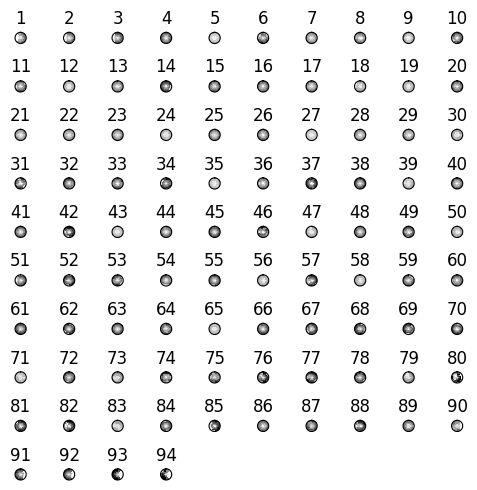

0

In [543]:
avg_vec_wt,center_dists_wt = polar_hist(flc_wt,n_segments_wt,intensities_wt,thetas_wt,dists_wt.*scale_corr,centers_wt)
IJulia.clear_output()

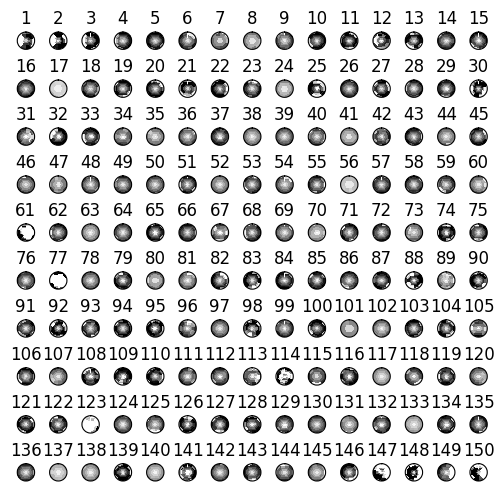

0

In [544]:
avg_vec_mut,center_dists_mut = polar_hist(flc_mut,n_segments_mut,intensities_mut,thetas_mut,dists_mut.*scale_corr,centers_mut)
IJulia.clear_output()

In [545]:
colors_wt = Array{Tuple{Float64,Float64,Float64}}(undef,n_segments_wt)
for roi = 1:n_segments_wt
   colors_wt[roi] = color_calc(roi,center_dists_wt)
end

colors_mut = Array{Tuple{Float64,Float64,Float64}}(undef,n_segments_mut)
for roi = 1:n_segments_mut
   colors_mut[roi] = color_calc(roi,center_dists_mut)
end



In [546]:
cbar = Array{Tuple{Float64,Float64,Float64}}(undef,300)
for row = 1:300
    r = row/300
    col = (r,0,1-r)
    cbar[row] = col
end
cbar_w = 30
cbar_exp = Array{Tuple{Float64,Float64,Float64}}(undef,cbar_w,300)
for w = 1:cbar_w
   cbar_exp[w,:] .= cbar
end

In [547]:
size(cbar_exp)

(30, 300)

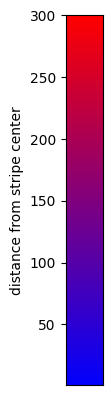

In [548]:
imshow(cbar_exp')

ylabel("distance from stripe center")
ylim(1,300)
xticks([])
savefig("colorbar.svg")

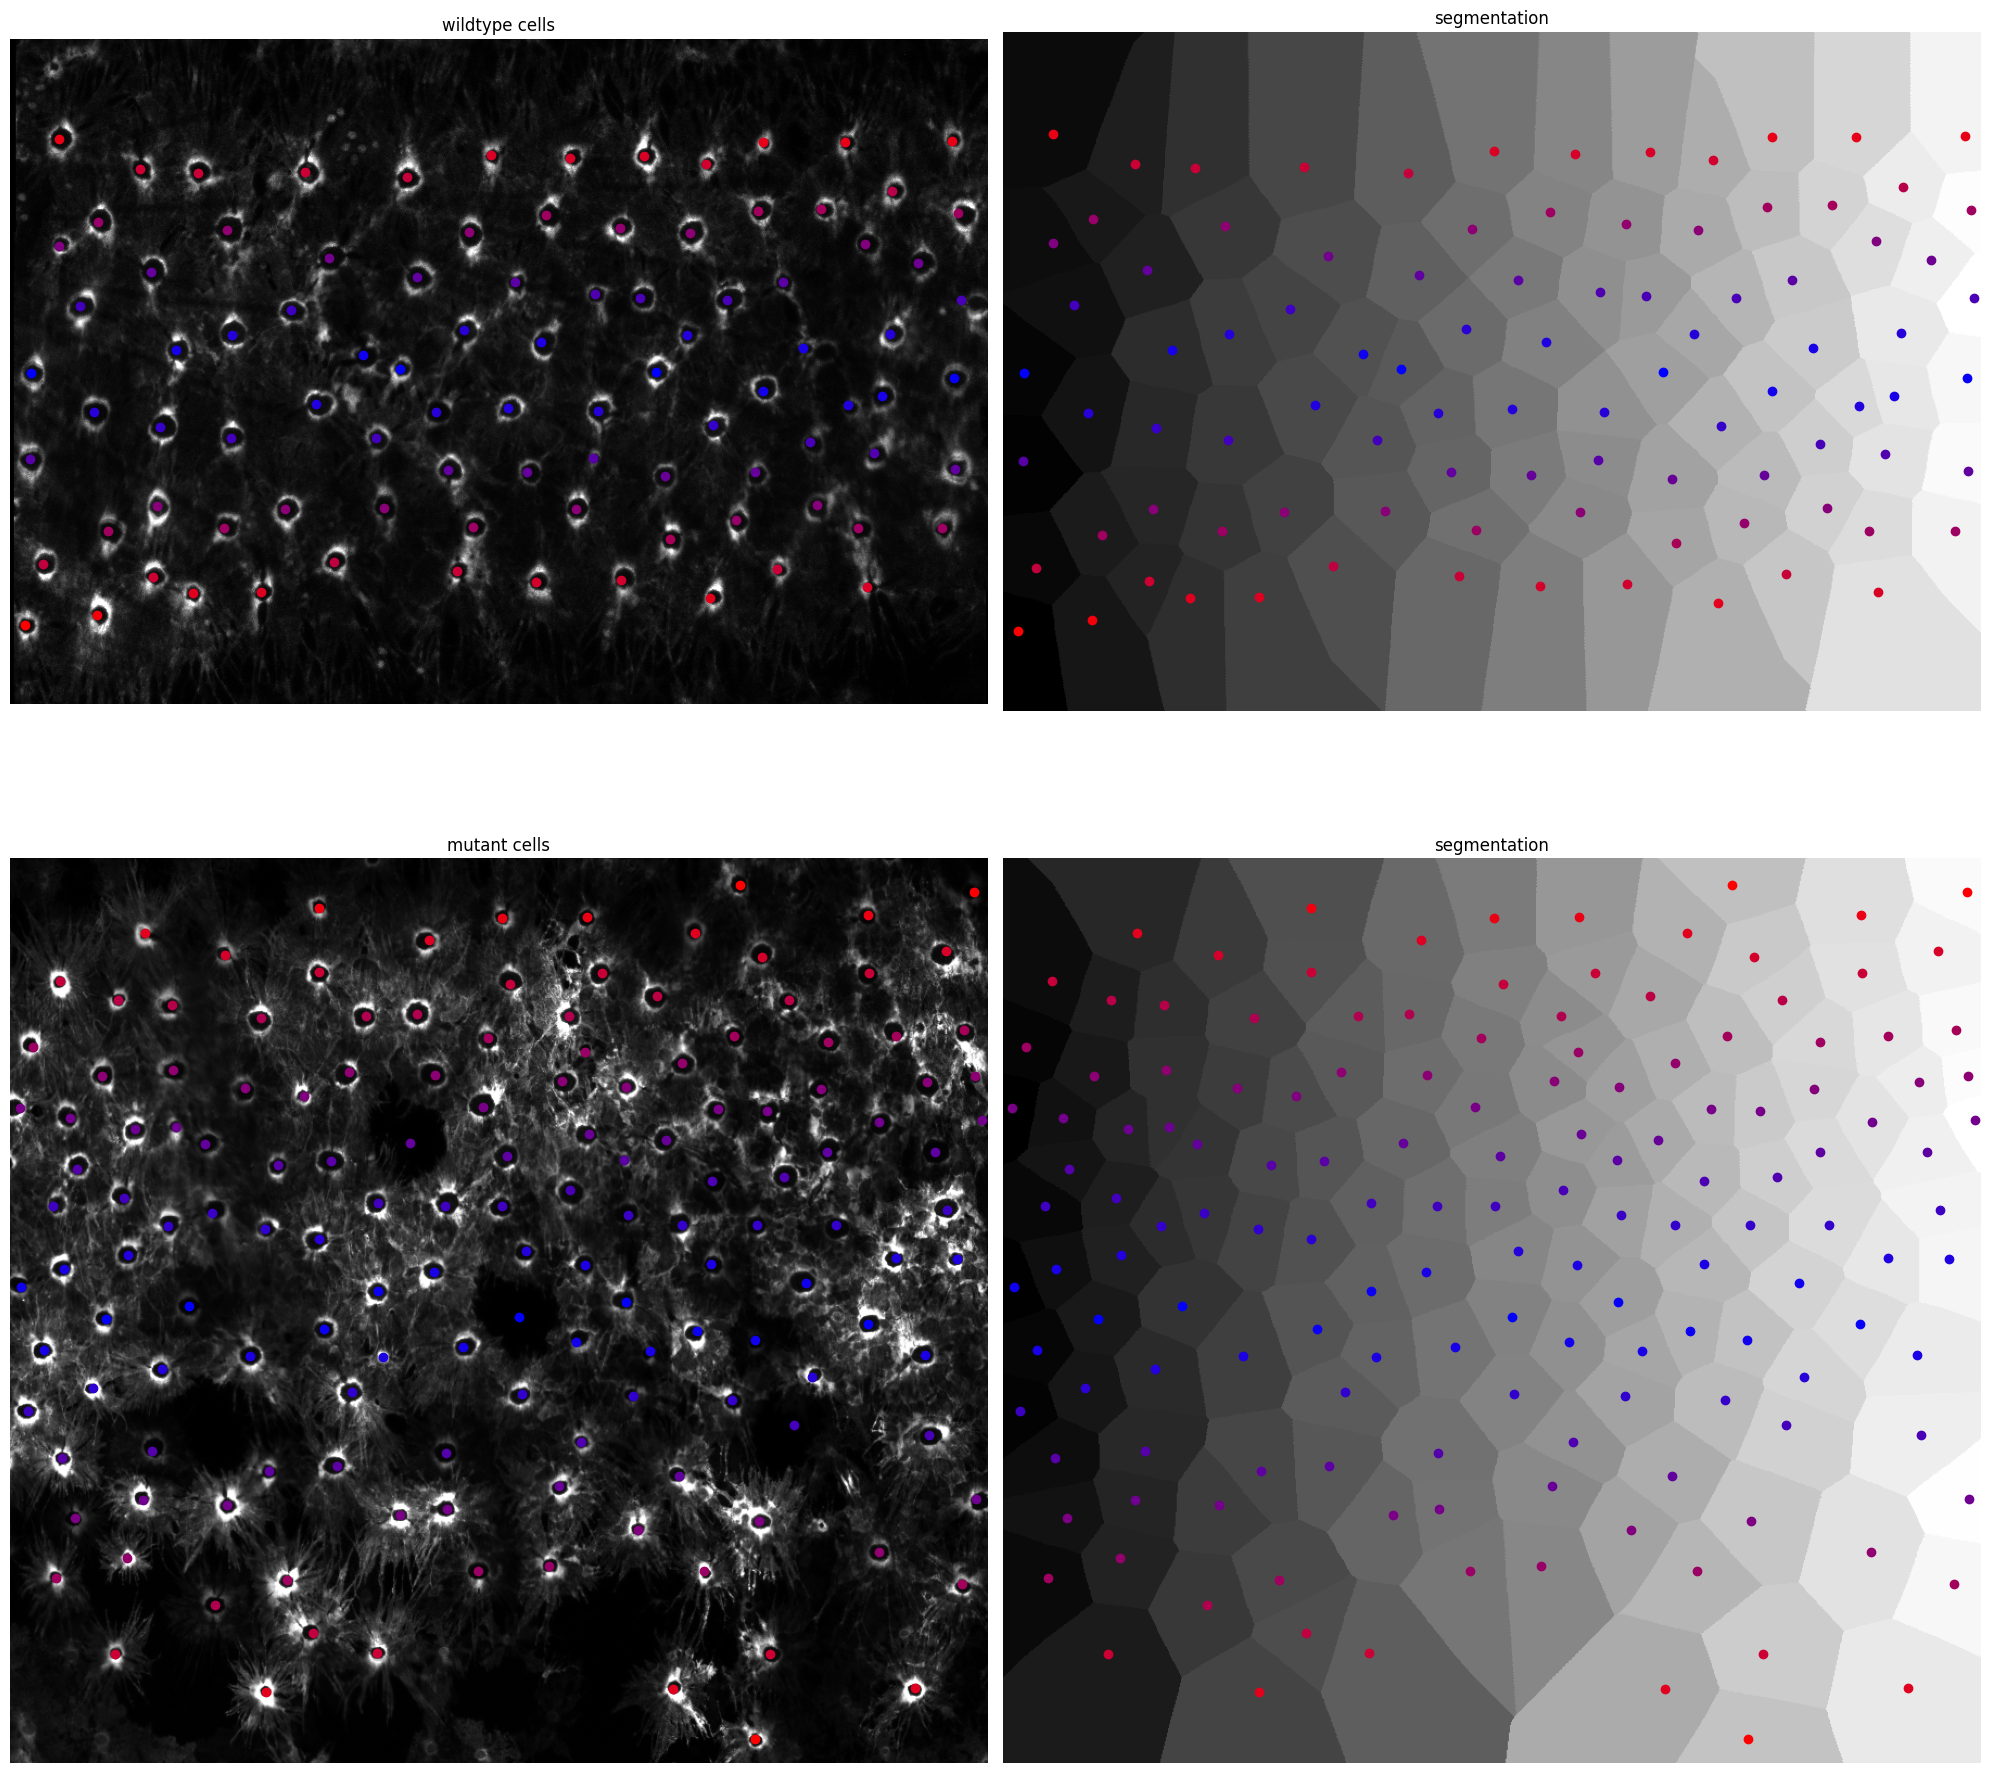

In [549]:
plt.figure(figsize=(20,20))

subplot(221)
plt.title("wildtype cells")
imshowt(flc_wt)
for c = 1:length(centers_wt[:,1])-1
    col=colors_wt[c]
    scatter(centers_wt[c,2],centers_wt[c,1],c=col)
    axis("off")
end
subplot(222)
plt.title("segmentation")
imshowt(labels_wt)
for c = 1:length(centers_wt[:,1])-1
    col=colors_wt[c]
    scatter(centers_wt[c,2],centers_wt[c,1],c=col)
    axis("off")
end
subplot(223)

scale_corr = 3
plt.title("mutant cells")
imshowt(flc_mut)
for c = 1:length(centers_mut[:,1])-1
    col = colors_mut[c]
    scatter(centers_mut[c,2],centers_mut[c,1],c=col)
    axis("off")
end
subplot(224)
plt.title("segmentation")
imshowt(labels_mut)
for c = 1:length(centers_mut[:,1])-1
    col = colors_mut[c]
    scatter(centers_mut[c,2],centers_mut[c,1],c=col)
    axis("off")
end
tight_layout()
plt.savefig("segmentation.svg")

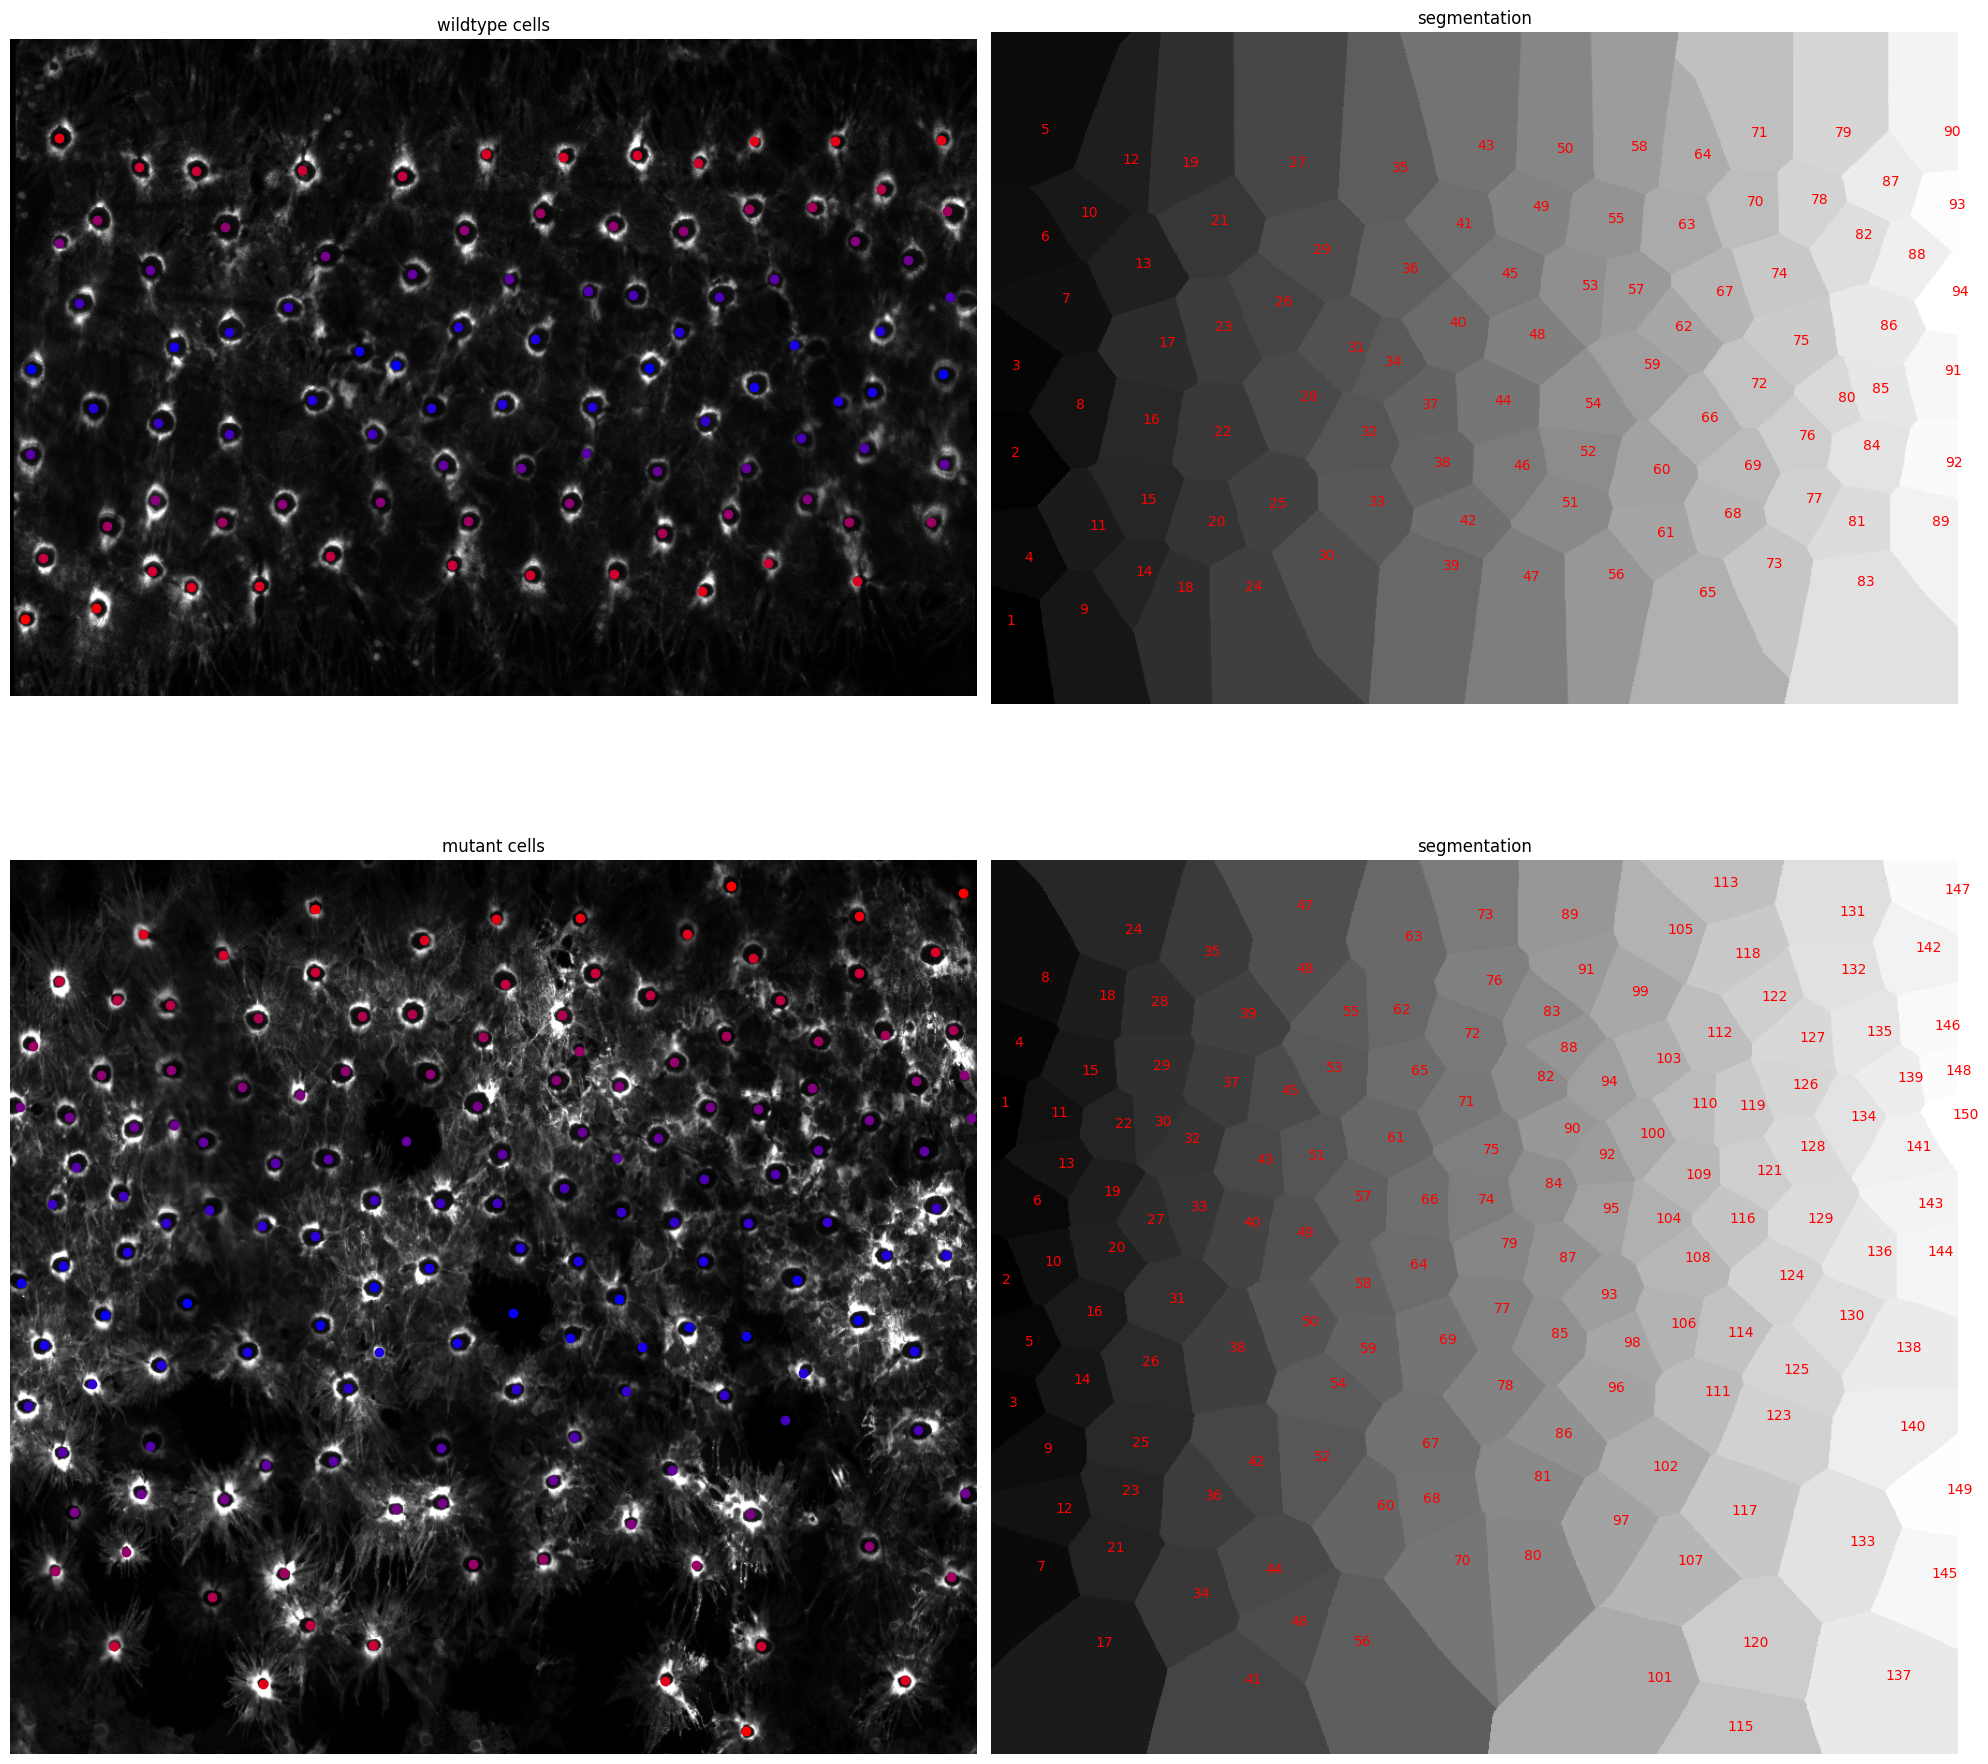

In [550]:
plt.figure(figsize=(20,20))

subplot(221)
plt.title("wildtype cells")
imshowt(flc_wt)
for c = 1:length(centers_wt[:,1])-1
    col=colors_wt[c]
    scatter(centers_wt[c,2],centers_wt[c,1],c=col)
    axis("off")
end
subplot(222)
plt.title("segmentation")
imshowt(labels_wt)
for c = 1:length(centers_wt[:,1])-1
    text(centers_wt[c,2],centers_wt[c,1],c,c="red")
end
subplot(223)

scale_corr = 3
plt.title("mutant cells")
imshowt(flc_mut)
for c = 1:length(centers_mut[:,1])-1
    col = colors_mut[c]
    scatter(centers_mut[c,2],centers_mut[c,1],c=col)
    axis("off")
end
subplot(224)
plt.title("segmentation")
imshowt(labels_mut)
for c = 1:length(centers_mut[:,1])-1
    text(centers_mut[c,2],centers_mut[c,1],c,c="red")
end
tight_layout()


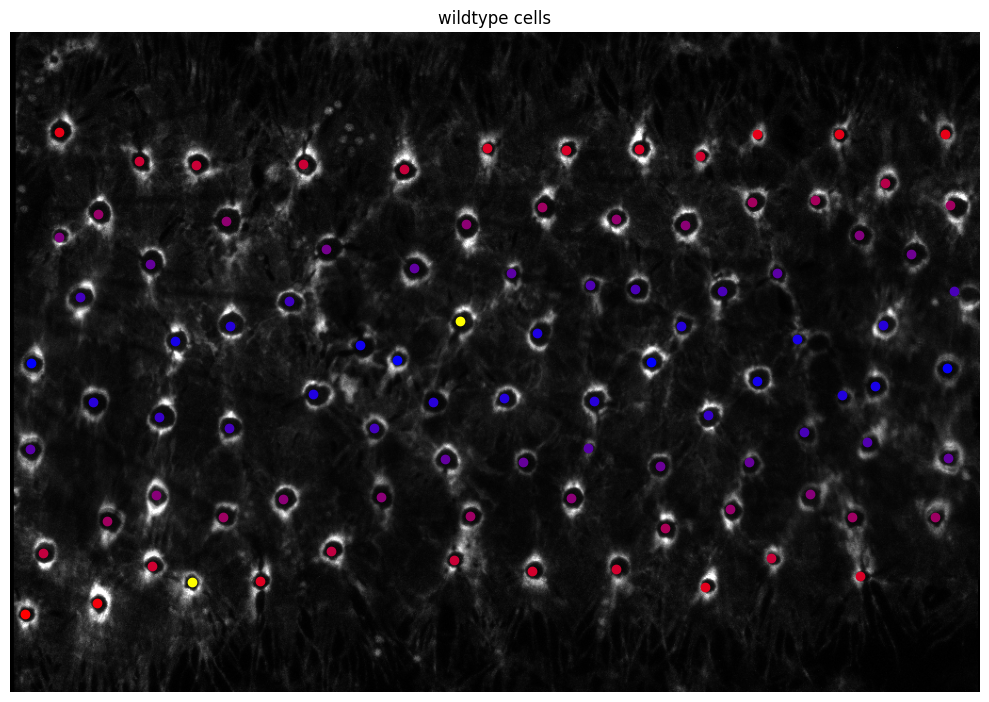

In [571]:
plt.figure(figsize=(10,10))

subplot(111)
plt.title("wildtype cells")
imshowt(flc_wt)
for c = 1:length(centers_wt[:,1])-1
    col=colors_wt[c]
    if c == 40 col = (1,1,0) end
    if c == 18 col = (1,1,0) end
    scatter(centers_wt[c,2],centers_wt[c,1],c=col)
    axis("off")
end

tight_layout()
plt.savefig("segmentation_annotated.svg")

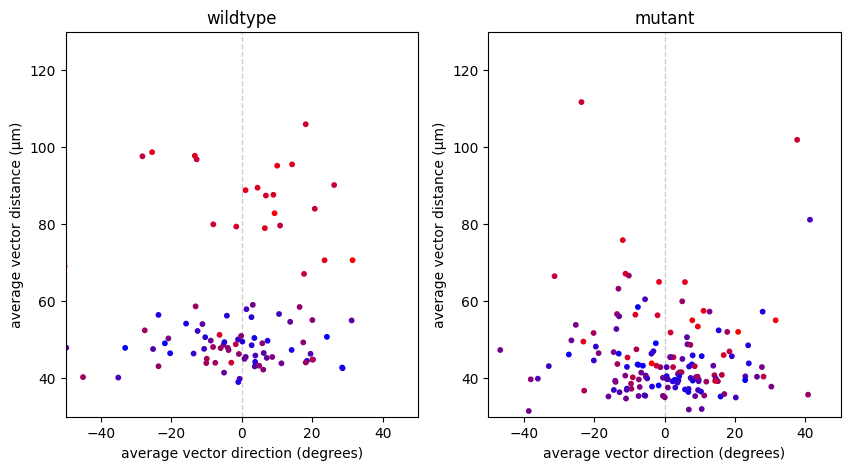

In [552]:
plt.figure(figsize=(10,5))
ax = plt.subplot(121)
plt.title("wildtype")
plt.scatter(rad2deg.(avg_vec_wt[:,1]),avg_vec_wt[:,2],c=colors_wt[:],s=10)
plt.axvline(0,0,100,linestyle="dashed",linewidth=1,alpha=0.2,color="black")
plt.ylim(30,130); 
plt.ylabel("average vector distance (µm)")
plt.xlabel("average vector direction (degrees)")
plt.xlim(-50,50)
#plt.xlim(-pi,pi)

ax = plt.subplot(122)
plt.title("mutant")
plt.scatter(rad2deg.(avg_vec_mut[:,1]),avg_vec_mut[:,2],c=colors_mut,s=10)
plt.axvline(0,0,100,linestyle="dashed",linewidth=1,alpha=0.2,color="black")
plt.ylim(30,130); 
plt.ylabel("average vector distance (µm)")
plt.xlabel("average vector direction (degrees)")
plt.xlim(-50,50)
#plt.xlim(-pi,pi)
#plt.xticks([])
#colorbar(cmap="coolwarm",label="distance from center (µm)")
plt.savefig("vector_strength.svg")

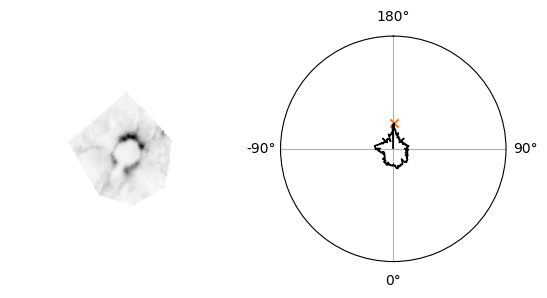

In [553]:
n_bins = 180
ymax = 250

roi = 40
mask_idx = findall(labels_map(segments_wt).!==roi)
masked_flc = copy(flc_wt)
for idx in mask_idx
   masked_flc[idx] = 0.0
end
label_idx = findall(labels_wt .== roi)
valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
t,d = thetas_wt[roi][valid_idx],dists_wt[roi][valid_idx]

ax = subplot(121)
roi_center = [Int(floor(centers_wt[roi,1])),Int(floor(centers_wt[roi,2]))]

offset=100
sub_img = Array{Float32}(masked_flc[roi_center[1]-offset:roi_center[1]+offset,roi_center[2]-offset:roi_center[2]+offset])
imshow(sub_img,cmap="gray_r")
axis("off")

ax = subplot(122,projection="polar")
c,b = hist(t,bins=n_bins,histtype="step",color="black")
max_c = maximum(c); max_idx = findall(c .== max_c); max_b = b[max_idx]
scatter(max_b,max_c,marker="x")
ax.set_rticks([]); ax.set_theta_zero_location("S")
xlim(-pi,pi); xticks([-0.5pi,0,0.5pi,pi])

ylim(0,ymax)
plt.xlabel(""); plt.ylabel("")
plt.savefig("intensity_cell1.svg")

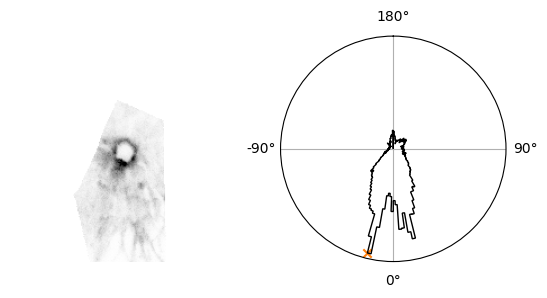

In [554]:
roi = 18 #10
n_bins=180
mask_idx = findall(labels_map(segments_wt).!==roi)
masked_flc = copy(flc_wt)
for idx in mask_idx
   masked_flc[idx] = 0.0
end
label_idx = findall(labels_wt .== roi)
valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
t,d = thetas_wt[roi][valid_idx],dists_wt[roi][valid_idx]

ax = subplot(121)
roi_center = [Int(floor(centers_wt[roi,1])),Int(floor(centers_wt[roi,2]))]
offset=100
sub_img = Array{Float32}(masked_flc[roi_center[1]-offset:roi_center[1]+offset,roi_center[2]-offset:roi_center[2]+offset])
imshow(sub_img,cmap="gray_r")
axis("off")

ax = subplot(122,projection="polar")
c,b = hist(t,bins=n_bins,histtype="step",color="black")
max_c = maximum(c); max_idx = findall(c .== max_c); max_b = b[max_idx]; scatter(max_b,max_c,marker="x")
ax.set_rticks([]); ax.set_theta_zero_location("S")
xlim(-pi,pi); xticks([-0.5pi,0,0.5pi,pi])
ylim(0,ymax)
plt.xlabel(""); plt.ylabel("")
plt.savefig("intensity_cell2.svg")

In [555]:
max_c = maximum(c)
max_idx = findall(c .== max_c)
max_b = b[max_idx]

1-element Vector{Float64}:
 -0.24354621276373223

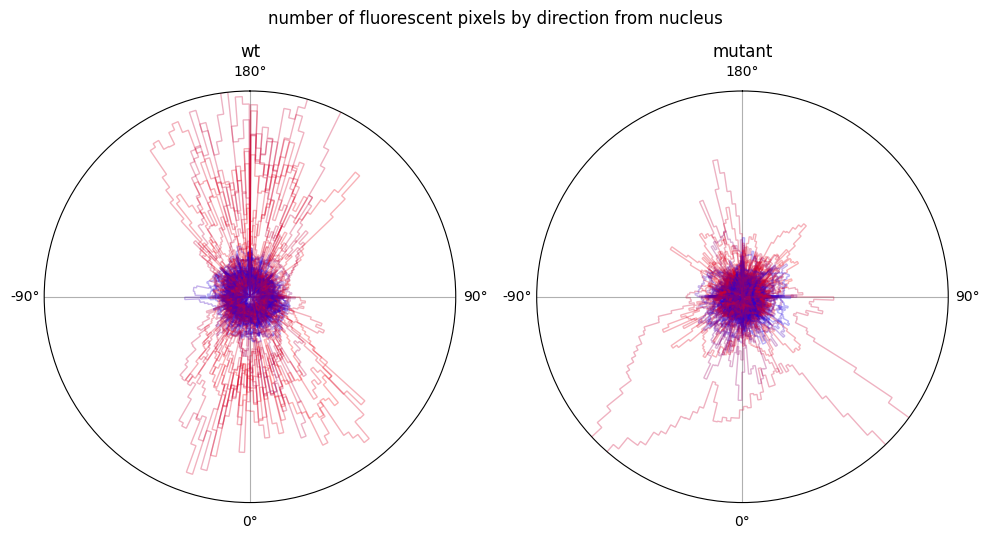

In [556]:
figure(figsize=(10,5.5))
suptitle("number of fluorescent pixels by direction from nucleus")
ymax=300
n_bins = 180

ax = subplot(121,projection="polar")
plt.title("wt")

total_area_wt = zeros(n_segments_wt)
max_freq_wt = zeros(n_segments_wt)
modal_angle_wt = zeros(n_segments_wt)

for roi = 1:n_segments_wt
    label_idx = findall(labels_wt .== roi)
    valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
    t = thetas_wt[roi][valid_idx]
    col = colors_wt[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color=col,alpha=0.3)
    total_area_wt[roi] = length(label_idx)
    max_freq_wt[roi] = maximum(c)
    max_idx = findall(c .== maximum(c))
    modal_angle_wt[roi] = b[max_idx[1]]
end

ax.set_rticks([]); ax.set_theta_zero_location("S")
xlim(-pi,pi); xticks([-0.5pi,0,0.5pi,pi])
ylim(0,ymax)
plt.xlabel(""); plt.ylabel("")

ax = subplot(122,projection="polar")
plt.title("mutant")

total_area_mut = zeros(n_segments_mut)
max_freq_mut = zeros(n_segments_mut)
modal_angle_mut = zeros(n_segments_mut)

for roi = 1:n_segments_mut
    label_idx = findall(labels_mut .== roi)
    valid_idx = findall(intensities_mut[roi] .> intensity_thresh)
    t = thetas_mut[roi][valid_idx]
    col = colors_mut[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color=col,alpha=0.3)
    total_area_mut[roi] = length(label_idx)
    max_freq_mut[roi] = maximum(c)
    max_idx = findall(c .== maximum(c))
    modal_angle_mut[roi] = b[max_idx[1]]
end

ax.set_rticks([]); ax.set_theta_zero_location("S")
xlim(-pi,pi); xticks([-0.5pi,0,0.5pi,pi])
ylim(0,ymax)
plt.xlabel(""); plt.ylabel("")

tight_layout()

plt.savefig("radial_intensity_histogram_allcells.svg")

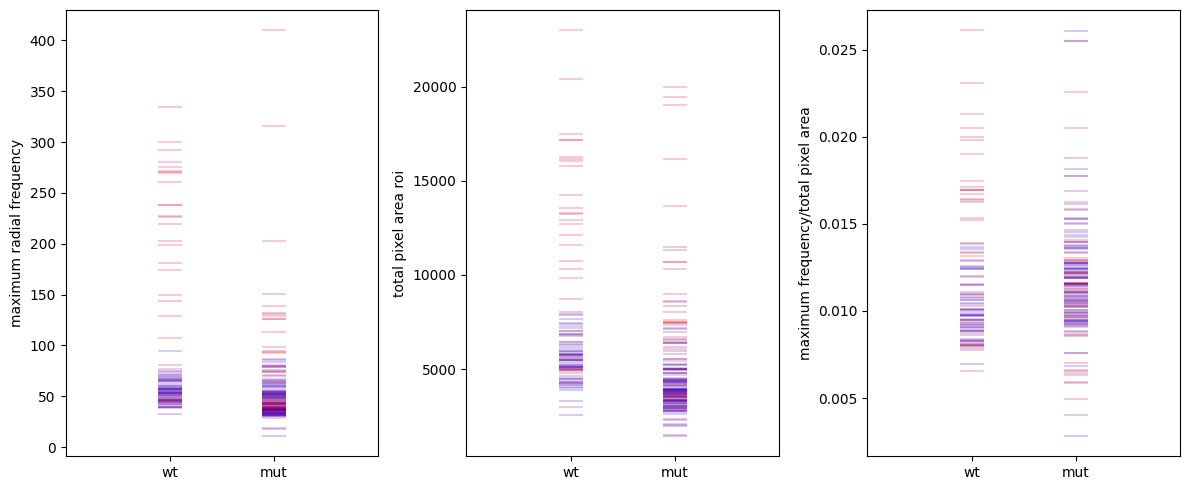

In [557]:
figure(figsize=(12,5))

s = 300
a = 0.2

subplot(131)
for roi = 2:n_segments_wt
    col = colors_wt[roi]
    scatter(1,max_freq_wt[roi],marker="_",c=col,s=s,alpha=a)
end

for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(1.5,max_freq_mut[roi],marker="_",c=col,s=s,alpha=a)
end

xlim(0.5,2)
xticks([1,1.5],["wt","mut"])
ylabel("maximum radial frequency")

subplot(132)
for roi = 2:n_segments_wt
    col = colors_wt[roi]
    scatter(1,total_area_wt[roi],marker="_",c=col,s=s,alpha=a)
end

for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(1.5,total_area_mut[roi],marker="_",c=col,s=s,alpha=a)
end

xlim(0.5,2)
xticks([1,1.5],["wt","mut"])
ylabel("total pixel area roi")

subplot(133)
for roi = 2:n_segments_wt
    col = colors_wt[roi]
    scatter(1,max_freq_wt[roi]./total_area_wt[roi],marker="_",c=col,s=s,alpha=a)
end

for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(1.5,max_freq_mut[roi]./total_area_mut[roi],marker="_",c=col,s=s,alpha=a)
end

xlim(0.5,2)
xticks([1,1.5],["wt","mut"])
ylabel("maximum frequency/total pixel area")

tight_layout()

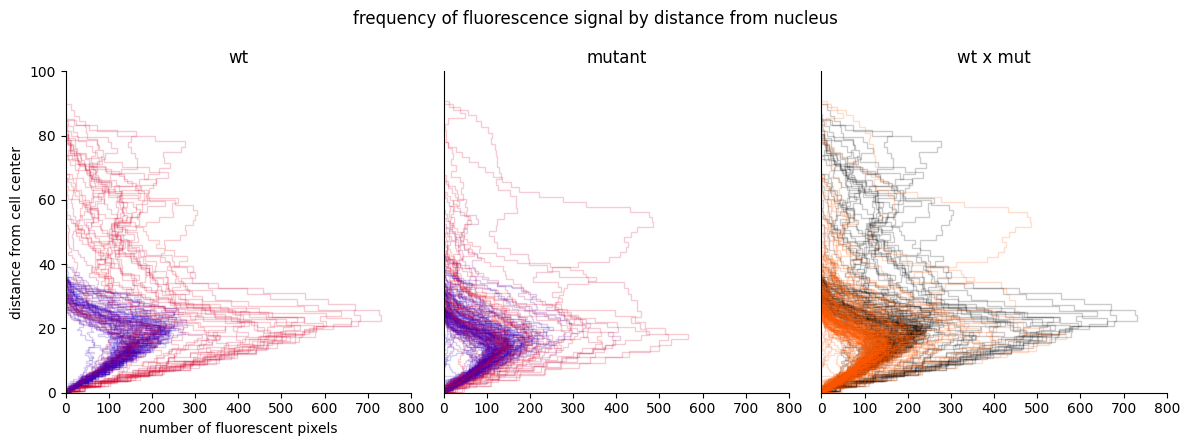

In [567]:
figure(figsize=(12,4.5))
suptitle("frequency of fluorescence signal by distance from nucleus")

xmax = 100
ymax= 800
n_bins = 50
a = 0.2

ax = subplot(131)
plt.title("wt")

max_dist_freq_wt = zeros(n_segments_wt)
modal_dist_wt = zeros(n_segments_wt)
max_dist_wt = zeros(n_segments_wt)

for roi = 1:n_segments_wt
    label_idx = findall(labels_wt .== roi)
    valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
    t = dists_wt[roi][valid_idx]
    col = colors_wt[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color=col,alpha=a,orientation="horizontal")
    max_dist_freq_wt[roi] = maximum(c)
    max_idx = findall(c .== maximum(c))
    modal_dist_wt[roi] = b[max_idx[1]]
    max_dist_wt[roi] = maximum(t)
end

ylim(0,xmax); xlim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.ylabel("distance from cell center"); plt.xlabel("number of fluorescent pixels")

ax = subplot(132)
plt.title("mutant")

max_dist_freq_mut = zeros(n_segments_mut)
modal_dist_mut = zeros(n_segments_mut)
max_dist_mut = zeros(n_segments_mut)

for roi = 1:n_segments_mut
    label_idx = findall(labels_mut .== roi)
    valid_idx = findall(intensities_mut[roi] .> intensity_thresh)
    t = dists_mut[roi][valid_idx]
    col = colors_mut[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color=col,alpha=a,orientation="horizontal")
    max_dist_freq_mut[roi] = maximum(c)
    max_idx = findall(c .== maximum(c))
    modal_dist_mut[roi] = b[max_idx[1]]
    max_dist_mut[roi] = maximum(t)
end

ylim(0,xmax); xlim(0,ymax)
plt.yticks([])
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.xlabel(""); plt.ylabel("")

ax = subplot(133)
title("wt x mut")
for roi = 1:n_segments_wt
    label_idx = findall(labels_wt .== roi)
    valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
    t = dists_wt[roi][valid_idx]
    c,b = hist(t,bins=n_bins,histtype="step",color=wt_color,alpha=a,orientation="horizontal")
end

for roi = 1:n_segments_mut
    label_idx = findall(labels_mut .== roi)
    valid_idx = findall(intensities_mut[roi] .> intensity_thresh)
    t = dists_mut[roi][valid_idx]
    col = colors_mut[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color=mut_color,alpha=a,orientation="horizontal")
end
plt.yticks([])
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
ylim(0,xmax); xlim(0,ymax)
plt.xlabel(""); plt.ylabel("")

tight_layout()

savefig("distance_histograms.svg")

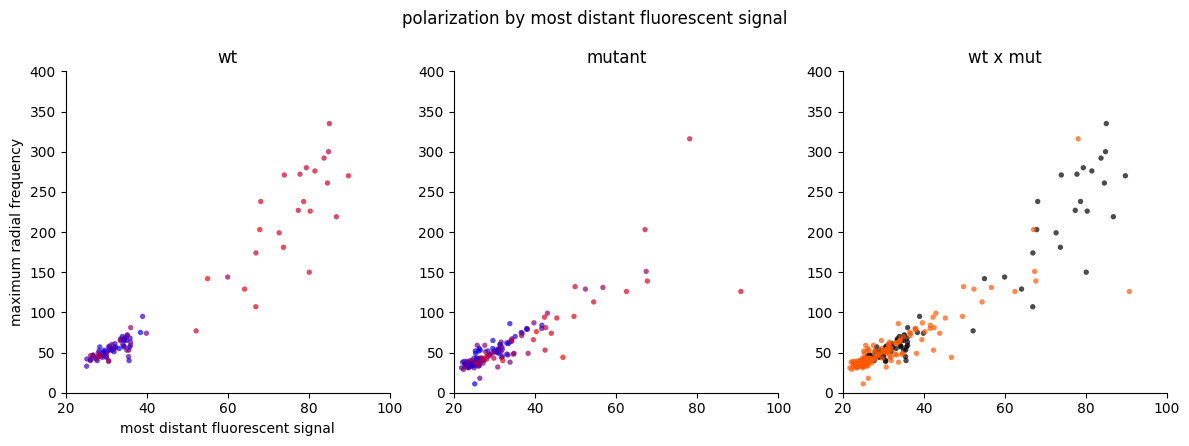

In [568]:
figure(figsize=(12,4.5))
suptitle("polarization by most distant fluorescent signal")

xmax = 100
ymax= 400
n_bins = 50
s,a = 15,0.7

ax = subplot(131)
plt.title("wt")

for roi = 1:n_segments_wt
    col = colors_wt[roi]
    scatter(max_dist_wt[roi],max_freq_wt[roi],c=col,s=s,alpha=a,edgecolor="none")
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.xlabel("most distant fluorescent signal"); plt.ylabel("maximum radial frequency")

ax = subplot(132)
plt.title("mutant")

for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(max_dist_mut[roi],max_freq_mut[roi],c=col,s=s,alpha=a,edgecolor="none")
end

ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
xlim(20,xmax); ylim(0,ymax)

ax = subplot(133)
plt.title("wt x mut")

for roi = 1:n_segments_wt
    scatter(max_dist_wt[roi],max_freq_wt[roi],c=wt_color,s=s,alpha=a,edgecolor="none")
end

for roi = 1:n_segments_mut
    scatter(max_dist_mut[roi],max_freq_mut[roi],c=mut_color,s=s,alpha=a,edgecolor="none")
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.xlabel(""); plt.ylabel("")

tight_layout()

savefig("polarization_by_distance.svg")

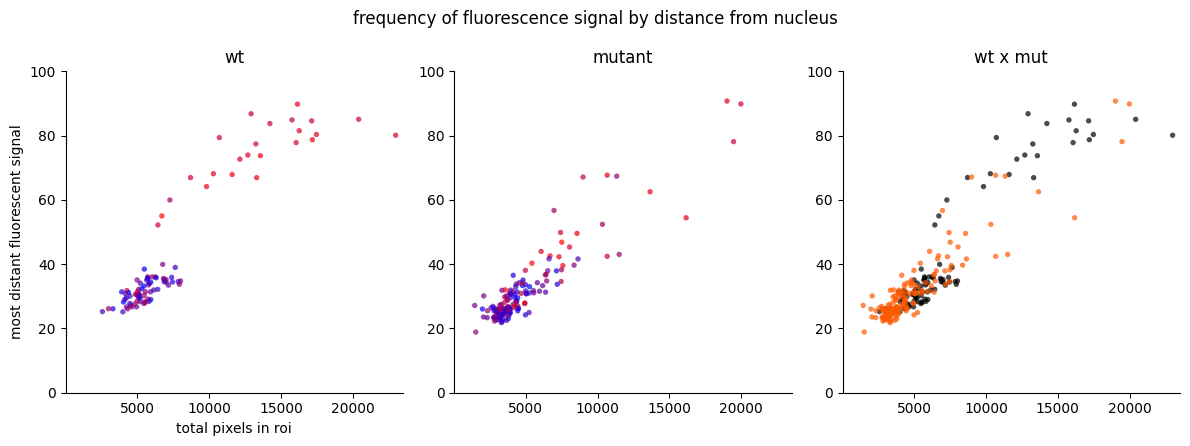

In [569]:
figure(figsize=(12,4.5))
suptitle("frequency of fluorescence signal by distance from nucleus")

ymax = 100
xmax= 23500
n_bins = 50
s,a = 15,0.7

ax = subplot(131)
plt.title("wt")

for roi = 1:n_segments_wt
    col = colors_wt[roi]
    scatter(total_area_wt[roi],max_dist_wt[roi],c=col,s=s,alpha=a,edgecolor="none")
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.ylabel("most distant fluorescent signal"); plt.xlabel("total pixels in roi")

ax = subplot(132)
plt.title("mutant")

for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(total_area_mut[roi],max_dist_mut[roi],c=col,s=s,alpha=a,edgecolor="none")
end

ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
xlim(20,xmax); ylim(0,ymax)

ax = subplot(133)
plt.title("wt x mut")

for roi = 1:n_segments_wt
    scatter(total_area_wt[roi],max_dist_wt[roi],c=wt_color,s=s,alpha=a,edgecolor="none")
end

for roi = 1:n_segments_mut
    scatter(total_area_mut[roi],max_dist_mut[roi],c=mut_color,s=s,alpha=a,edgecolor="none")
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.xlabel(""); plt.ylabel("")

tight_layout()

savefig("pixel_area_distance_control.svg")

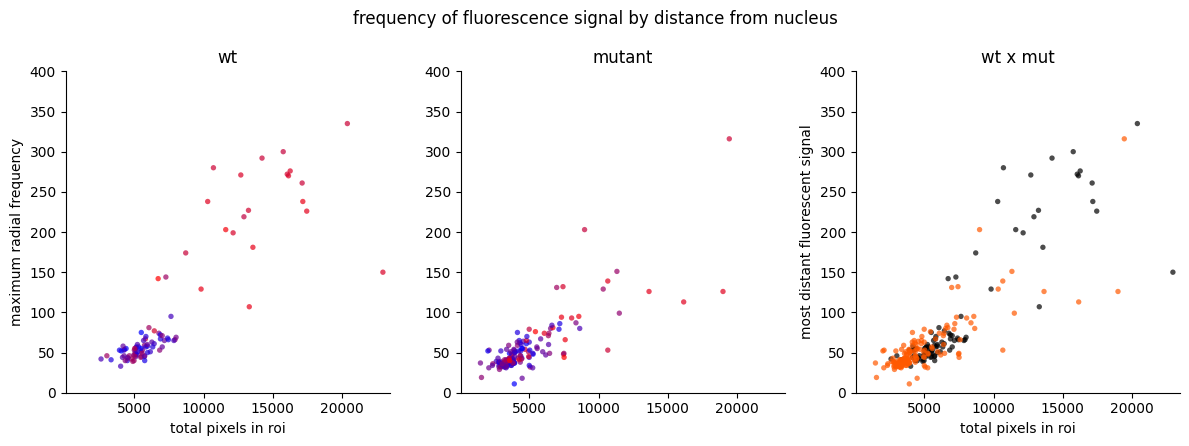

In [655]:
figure(figsize=(12,4.5))
suptitle("frequency of fluorescence signal by distance from nucleus")

ymax = 400
xmax= 23500
n_bins = 50
s,a = 15,0.7

ax = subplot(131)
plt.title("wt")

for roi = 1:n_segments_wt
    col = colors_wt[roi]
    scatter(total_area_wt[roi],max_freq_wt[roi],c=col,s=s,alpha=a,edgecolor="none")
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.ylabel("maximum radial frequency"); plt.xlabel("total pixels in roi")

ax = subplot(132)
plt.title("mutant")

for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(total_area_mut[roi],max_freq_mut[roi],c=col,s=s,alpha=a,edgecolor="none")
end

ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
xlim(20,xmax); ylim(0,ymax)

ax = subplot(133)
plt.title("wt x mut")

for roi = 1:n_segments_wt
    scatter(total_area_wt[roi],max_freq_wt[roi],c=wt_color,s=s,alpha=a,edgecolor="none")
end

for roi = 1:n_segments_mut
    scatter(total_area_mut[roi],max_freq_mut[roi],c=mut_color,s=s,alpha=a,edgecolor="none")
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.ylabel("most distant fluorescent signal"); plt.xlabel("total pixels in roi")

tight_layout()
savefig("pixel_area_polarization_control.svg")

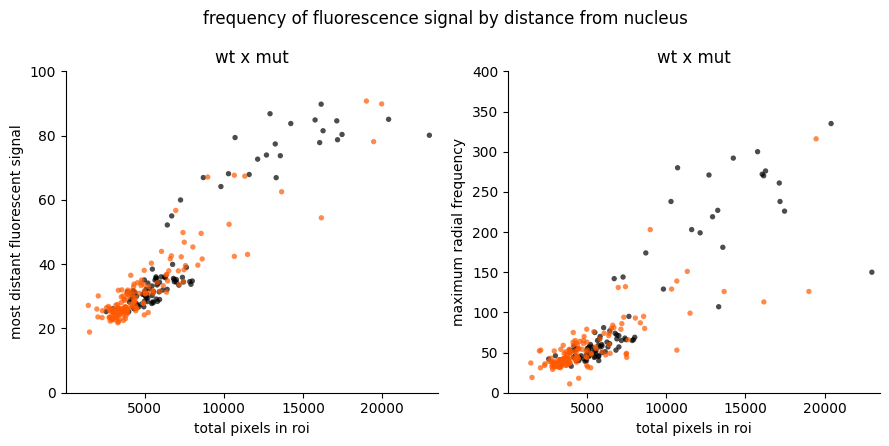

In [660]:
figure(figsize=(9,4.5))
suptitle("frequency of fluorescence signal by distance from nucleus")

ymax = 100
xmax= 23500
n_bins = 50
s,a = 15,0.7

ax = subplot(121)
plt.title("wt x mut")

for roi = 1:n_segments_wt
    scatter(total_area_wt[roi],max_dist_wt[roi],c=wt_color,s=s,alpha=a,edgecolor="none")
end

for roi = 1:n_segments_mut
    scatter(total_area_mut[roi],max_dist_mut[roi],c=mut_color,s=s,alpha=a,edgecolor="none")
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.ylabel("most distant fluorescent signal"); plt.xlabel("total pixels in roi")

ax = subplot(122)
plt.title("wt x mut")

for roi = 1:n_segments_wt
    scatter(total_area_wt[roi],max_freq_wt[roi],c=wt_color,s=s,alpha=a,edgecolor="none")
end

for roi = 1:n_segments_mut
    scatter(total_area_mut[roi],max_freq_mut[roi],c=mut_color,s=s,alpha=a,edgecolor="none")
end
ymax = 400
xmax= 23500
xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.ylabel("maximum radial frequency"); plt.xlabel("total pixels in roi")


tight_layout()

savefig("pixel_area_distance_control.svg")

In [576]:
using GaussianMixtures

In [580]:
model_input = hcat(max_dist_wt,max_freq_wt)

94×2 Matrix{Float64}:
 55.0076  142.0
 36.0171   63.0
 38.4627   75.0
 33.5342   67.0
 78.7163  238.0
 39.9339   74.0
 38.9916   95.0
 35.8944   68.0
 67.9008  203.0
 32.1623   56.0
 36.0521   81.0
 79.39    280.0
 33.4684   65.0
  ⋮       
 80.1092  150.0
 30.6163   53.0
 31.3888   53.0
 35.7625   57.0
 31.4389   55.0
 27.1697   43.0
 59.9755  144.0
 64.1493  129.0
 31.1595   55.0
 30.8458   58.0
 26.1454   46.0
 25.2426   42.0

In [585]:
gmm_model = GMM(2,model_input)

K-means converged with 4 iterations (objv = 78606.11063215238)


[ Info: Initializing GMM, 2 Gaussians diag covariance 2 dimensions using 94 data points
┌ Info: K-means with 94 data points using 4 iterations
└ 15.7 data points per parameter


GMM{Float64} with 2 components in 2 dimensions and diag covariance
Mix 1: weight 0.744271
  mean: [31.559537796344202, 54.62082035343639]
  variance: [12.28731521549264, 126.89882886501982]
Mix 2: weight 0.255729
  mean: [74.60218795658264, 216.92897196329855]
  variance: [100.44230639694342, 4358.379125009356]


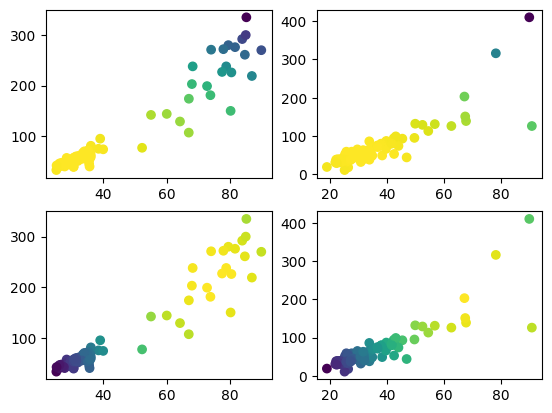

PyObject <matplotlib.collections.PathCollection object at 0x7f3960edd220>

In [650]:
ll_wt = llpg(gmm_model,model_input); ll_mut = llpg(gmm_model,hcat(max_dist_mut,max_freq_mut))

ecs=["black","red"]

subplot(221)
scatter(max_dist_wt,max_freq_wt,c=ll_wt[:,1]); 
subplot(222)
scatter(max_dist_mut,max_freq_mut,c=ll_mut[:,1])
subplot(223)
scatter(max_dist_wt,max_freq_wt,c=ll_wt[:,2]); 
subplot(224)
scatter(max_dist_mut,max_freq_mut,c=ll_mut[:,2])

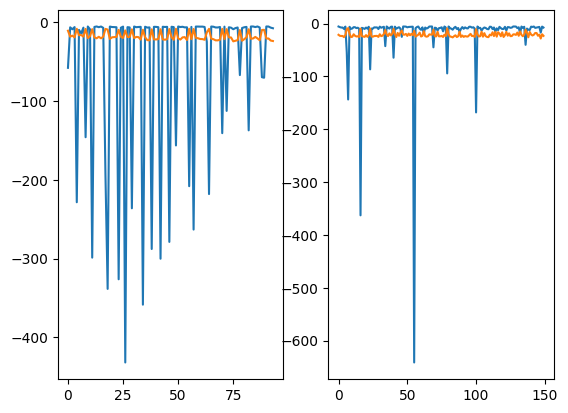

2-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f396e92d2e0>
 PyObject <matplotlib.lines.Line2D object at 0x7f396e92de20>

In [653]:
subplot(121)
plot(ll_wt)

subplot(122)
plot(ll_mut)


In [664]:
clust_ident_wt = zeros(n_segments_wt)
for roi = 1:n_segments_wt
    ll = ll_wt[roi,1]
    if ll > -50
        clust_ident_wt[roi] = 1
    end
end
clust_ident_mut = zeros(n_segments_mut)
for roi = 1:n_segments_mut
    ll = ll_mut[roi,1]
    if ll > -50
        clust_ident_mut[roi] = 1
    end
end
IJulia.clear_output()

0

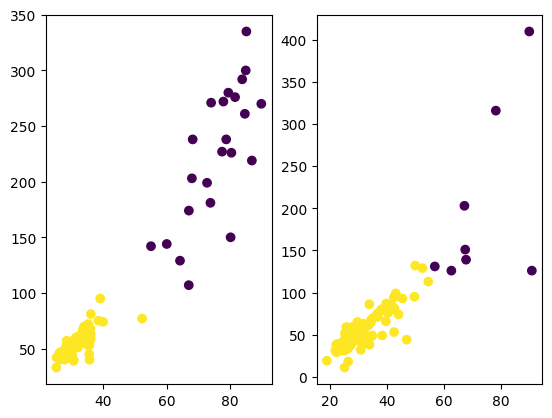

PyObject <matplotlib.collections.PathCollection object at 0x7f396e9b98b0>

In [651]:
ll_wt = llpg(gmm_model,model_input); ll_mut = llpg(gmm_model,hcat(max_dist_mut,max_freq_mut))
ax = subplot(121)
scatter(max_dist_wt,max_freq_wt,c=clust_ident_wt); 
ax = subplot(122)
scatter(max_dist_mut,max_freq_mut,c=clust_ident_mut)

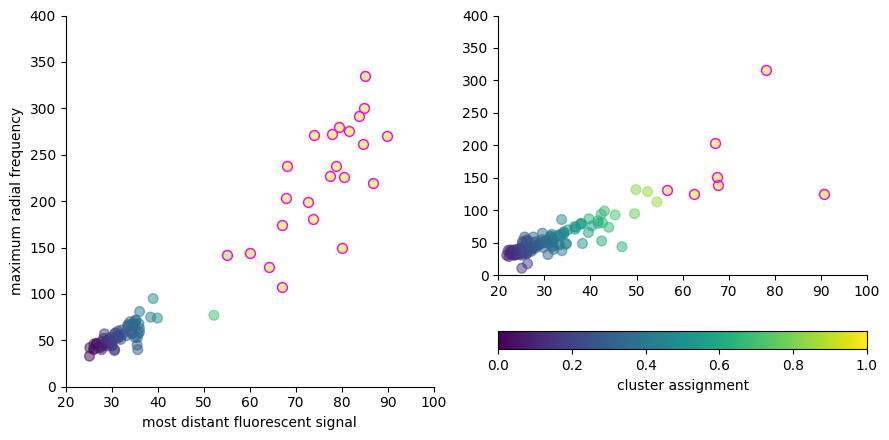

In [717]:
figure(figsize=(9,4.5))
ecs=["magenta",(0,0,0,0)]
xmax = 100
ymax= 400
s = 50
a = 0.5

ax = subplot(121)

scatter(max_dist_wt,max_freq_wt,c=ll_wt[:,2],s=s,alpha=a); 
for roi = 1:n_segments_wt
    scatter(max_dist_wt[roi],max_freq_wt[roi],c=(0,0,0,0),edgecolor=ecs[Int(clust_ident_wt[roi])+1],linewidth=1,s=s); 
end

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
plt.xlabel("most distant fluorescent signal"); plt.ylabel("maximum radial frequency")

ax = subplot(122)
scatter(max_dist_mut,max_freq_mut,c=ll_mut[:,2],s=s,alpha=a)
for roi = 1:n_segments_mut
    scatter(max_dist_mut[roi],max_freq_mut[roi],c=(0,0,0,0),edgecolor=ecs[Int(clust_ident_mut[roi])+1],linewidth=1,s=s); 
end
#cax = plt.axes()
#    ax_cb = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(label="cluster assignment", orientation="horizontal")

xlim(20,xmax); ylim(0,ymax)
ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
#plt.xlabel("most distant fluorescent signal"); plt.ylabel("maximum radial frequency")
tight_layout()


savefig("gmm_clustering_ll_colorbar.svg")

In [645]:
using HypothesisTests
conting_table = Matrix{Int64}(zeros(2,2))

conting_table[1,1] = Int(sum(clust_ident_wt))
conting_table[2,1] = length(clust_ident_wt) - sum(clust_ident_wt)
conting_table[1,2] = sum(clust_ident_mut)
conting_table[2,2] = length(clust_ident_mut) - sum(clust_ident_mut)

8.0

In [646]:
ChisqTest(conting_table)

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.336301, 0.0489452, 0.53665, 0.078104]
    point estimate:          [0.290984, 0.0942623, 0.581967, 0.0327869]
    95% confidence interval: [(0.2295, 0.3554), (0.03279, 0.1587), (0.5205, 0.6464), (0.0, 0.09719)]

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-04

Details:
    Sample size:        244
    statistic:          19.07714176771144
    degrees of freedom: 1
    residuals:          [-1.22066, 3.19965, 0.966299, -2.53291]
    std. residuals:     [-4.36774, 4.36774, 4.36774, -4.36774]


In [718]:
conting_table

2×2 Matrix{Int64}:
 71  142
 23    8

In [602]:
size(posterior[1][:,1])

(94,)

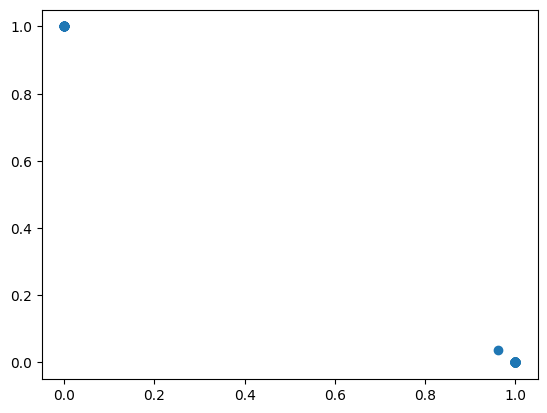

PyObject <matplotlib.collections.PathCollection object at 0x7f39640c7a90>

In [605]:
cluster_ident_wt = 

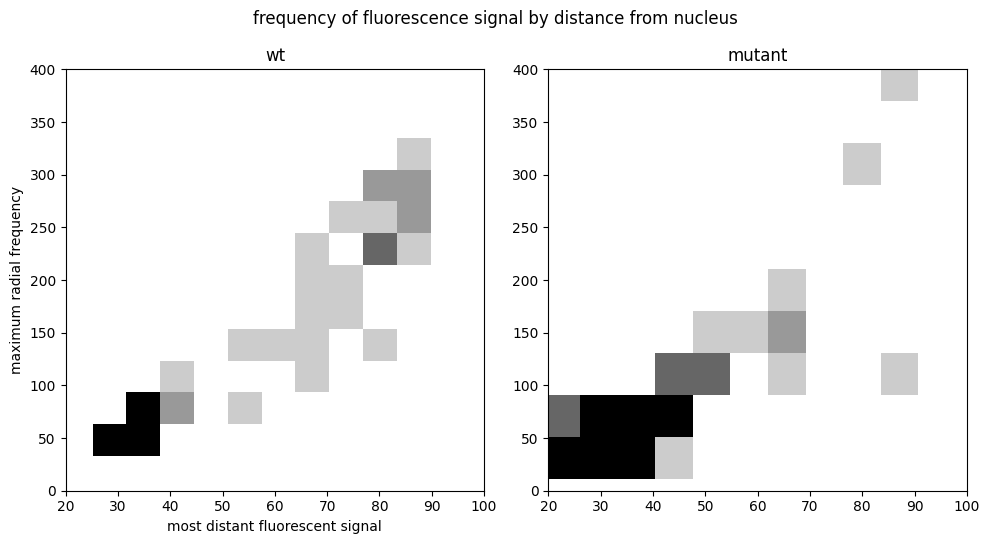

In [562]:
figure(figsize=(10,5.5))
suptitle("frequency of fluorescence signal by distance from nucleus")

xmax = 100
ymax= 400
vmax = 5

ax = subplot(121)
plt.title("wt")

plt.hist2d(max_dist_wt,max_freq_wt,cmap="gray_r",vmax=vmax)

xlim(20,xmax); ylim(0,ymax)
plt.xlabel("most distant fluorescent signal"); plt.ylabel("maximum radial frequency")

ax = subplot(122)
plt.title("mutant")

plt.hist2d(max_dist_mut,max_freq_mut,cmap="gray_r",vmax=vmax)
xlim(20,xmax); ylim(0,ymax)
plt.xlabel(""); plt.ylabel("")

tight_layout()

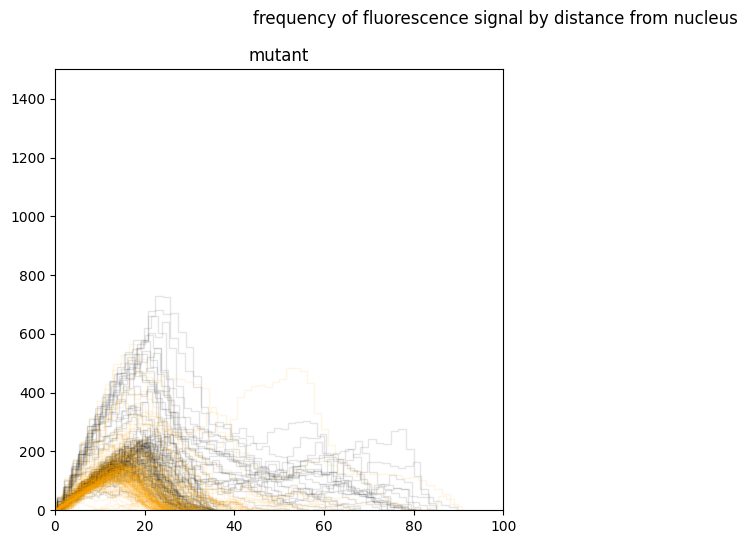

In [563]:
figure(figsize=(10,5.5))
suptitle("frequency of fluorescence signal by distance from nucleus")

xmax = 100
ymax=1500

ax = subplot(121)
plt.title("wt")

max_dist_freq_wt = zeros(n_segments_wt)
modal_dist_wt = zeros(n_segments_wt)

for roi = 1:n_segments_wt
    label_idx = findall(labels_wt .== roi)
    valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
    t = dists_wt[roi][valid_idx]
    col = colors_wt[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color="black",alpha=0.1)
    max_dist_freq_wt[roi] = maximum(c)
    max_idx = findall(c .== maximum(c))
    modal_dist_wt[roi] = b[max_idx[1]]
end

xlim(0,xmax); ylim(0,ymax)
plt.xlabel("distance from nucleus"); plt.ylabel("frequency")

plt.title("mutant")

max_dist_freq_mut = zeros(n_segments_mut)
modal_dist_mut = zeros(n_segments_mut)

for roi = 1:n_segments_mut
    label_idx = findall(labels_mut .== roi)
    valid_idx = findall(intensities_mut[roi] .> intensity_thresh)
    t = dists_mut[roi][valid_idx]
    col = colors_mut[roi]
    c,b = hist(t,bins=n_bins,histtype="step",color="orange",alpha=0.1)
    max_dist_freq_mut[roi] = maximum(c)
    max_idx = findall(c .== maximum(c))
    modal_dist_mut[roi] = b[max_idx[1]]
end

xlim(0,xmax); ylim(0,ymax)
plt.xlabel(""); plt.ylabel("")

tight_layout()

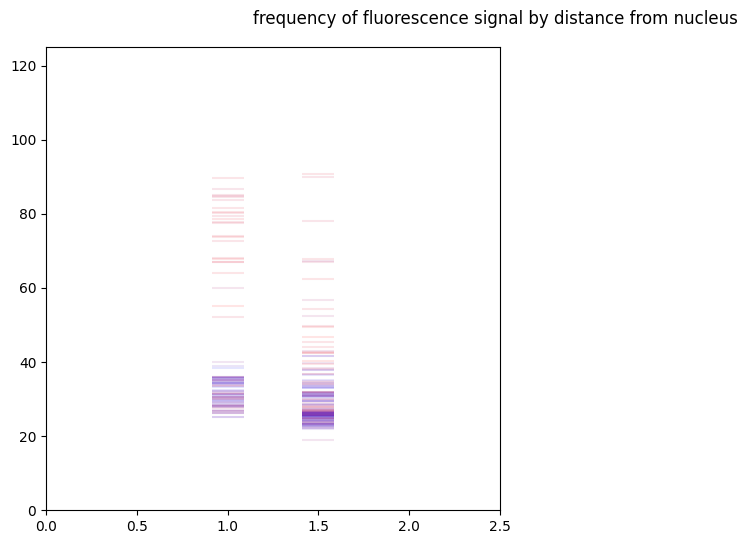

In [564]:
figure(figsize=(10,5.5))
suptitle("frequency of fluorescence signal by distance from nucleus")

xmax = 100
ymax= 1000
s = 500
a = 0.1

ax = subplot(121)
#plt.title("wt")

for roi = 1:n_segments_wt
    label_idx = findall(labels_wt .== roi)
    valid_idx = findall(intensities_wt[roi] .> intensity_thresh)
    t = dists_wt[roi][valid_idx]
    col = colors_wt[roi]
    scatter(1,maximum(t),c=col,marker="_",s=s,alpha=a)
end

#xlim(0,xmax); ylim(0,ymax)
#plt.xlabel("distance from nucleus"); plt.ylabel("frequency")

#ax = subplot(122)
#plt.title("mutant")

for roi = 1:n_segments_mut
    label_idx = findall(labels_mut .== roi)
    valid_idx = findall(intensities_mut[roi] .> intensity_thresh)
    t = dists_mut[roi][valid_idx]
    col = colors_mut[roi]
    scatter(1.5,maximum(t),c=col,marker="_",s=s,alpha=a)
end

#xlim(0,xmax); ylim(0,ymax)
#plt.xlabel(""); plt.ylabel("")

xlim(0,2.5)
ylim(0,125)

tight_layout()

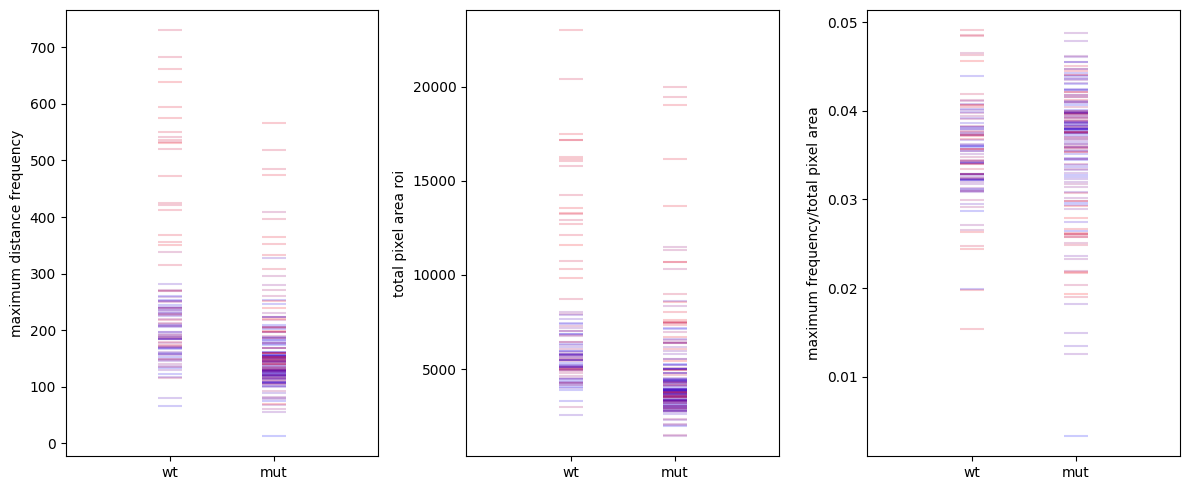

In [565]:
figure(figsize=(12,5))

s = 300
a = 0.2

subplot(131)
for roi = 2:n_segments_wt
    col = colors_wt[roi]
    scatter(1,max_dist_freq_wt[roi],marker="_",c=col,s=s,alpha=a)
end

for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(1.5,max_dist_freq_mut[roi],marker="_",c=col,s=s,alpha=a)
end

xlim(0.5,2)
xticks([1,1.5],["wt","mut"])
ylabel("maximum distance frequency")

subplot(132)
for roi = 2:n_segments_wt
    col = colors_wt[roi]
    scatter(1,total_area_wt[roi],marker="_",c=col,s=s,alpha=a)
end

for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(1.5,total_area_mut[roi],marker="_",c=col,s=s,alpha=a)
end

xlim(0.5,2)
xticks([1,1.5],["wt","mut"])
ylabel("total pixel area roi")

subplot(133)
for roi = 2:n_segments_wt
    col = colors_wt[roi]
    scatter(1,max_dist_freq_wt[roi]./total_area_wt[roi],marker="_",c=col,s=s,alpha=a)
end

for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(1.5,max_dist_freq_mut[roi]./total_area_mut[roi],marker="_",c=col,s=s,alpha=a)
end

xlim(0.5,2)
xticks([1,1.5],["wt","mut"])
ylabel("maximum frequency/total pixel area")

tight_layout()

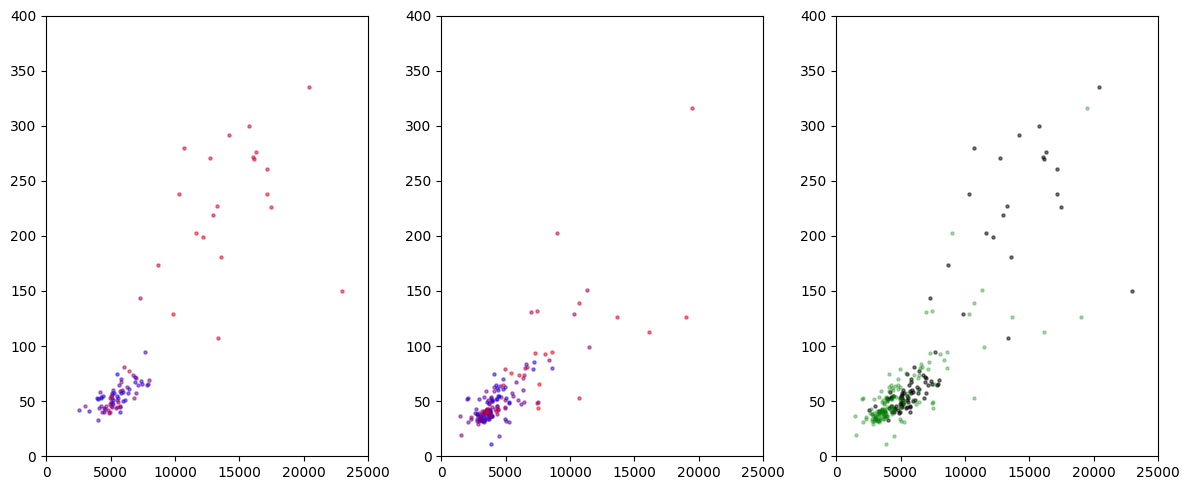

In [566]:
figure(figsize=(12,5))
s,a=5,0.5

ymax = 400; xmax=25000

subplot(131)
for roi = 2:n_segments_wt
    col = colors_wt[roi]
    scatter(total_area_wt[roi],max_freq_wt[roi],c=col,s=s,alpha=a)
end
ylim(0,ymax); xlim(0,xmax)

subplot(132)
for roi = 1:n_segments_mut
    col = colors_mut[roi]
    scatter(total_area_mut[roi],max_freq_mut[roi],c=col,s=s,alpha=a)
end
ylim(0,ymax); xlim(0,xmax)

subplot(133)
for roi = 2:n_segments_wt
    col = "black"
    scatter(total_area_wt[roi],max_freq_wt[roi],c=col,s=s,alpha=a)
end

for roi = 1:n_segments_mut
    col = "green"
    scatter(total_area_mut[roi],max_freq_mut[roi],c=col,s=s,alpha=0.3)
end
ylim(0,ymax); xlim(0,xmax)

tight_layout()